## Advanced Lane Finding Project 
### by Abanoub David Awad 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


We'll start off our notebook by importing our packages.


In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
from math import floor
from math import fabs
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

print("modules loaded")

modules loaded


## First, let's compute the camera calibration Matrix using chessboard images taken with our sample camera. 


We make the adjustment for a 9x6 chessboard in our new images. 

We iterate through all of the images and mark where the actual vertices of the chessboard are in all of the images and then feed our 20 examples to openCV to compute the camera calibration matrix. 


About to calibrate camera using 20 sample images
Processing image 0
Processing image 1
processed camera_cal/calibration10.jpg
Processing image 2
processed camera_cal/calibration11.jpg
Processing image 3
processed camera_cal/calibration12.jpg
Processing image 4
processed camera_cal/calibration13.jpg
Processing image 5
processed camera_cal/calibration14.jpg
Processing image 6
processed camera_cal/calibration15.jpg
Processing image 7
processed camera_cal/calibration16.jpg
Processing image 8
processed camera_cal/calibration17.jpg
Processing image 9
processed camera_cal/calibration18.jpg
Processing image 10
processed camera_cal/calibration19.jpg
Processing image 11
processed camera_cal/calibration2.jpg
Processing image 12
processed camera_cal/calibration20.jpg
Processing image 13
processed camera_cal/calibration3.jpg
Processing image 14
Processing image 15
Processing image 16
processed camera_cal/calibration6.jpg
Processing image 17
processed camera_cal/calibration7.jpg
Processing image 18


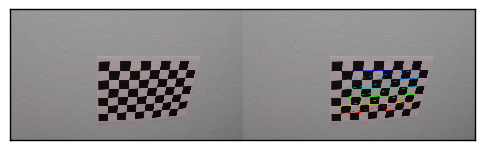

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objp = np.zeros( (nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# NOTE: the `jupyter notebook` command must be run from the same directory as the `camera_cal` folder. 
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

print("About to calibrate camera using %s sample images" % len(images))

# dummy vals
img, gray = None, None


# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    print("Processing image %s" % str(idx))
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # for notebook demonstration purposes
    if idx == 1: img_before = np.copy(img)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_marked' + str(idx) + '.jpg'
        cv2.imwrite(write_name, img)
        
        # for notebook demonstration purposes
        if idx == 1: img_after = np.copy(img)
        
        print("processed " + fname)


# use our set of image points and object points to approximate camera distortion matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# save the camera information for future use

# TODO do we need to save this
# cal_cam? bad name.  
cal_cam = {}
cal_cam['ret'] = ret  
cal_cam['mtx'] = mtx     # camera matrix
cal_cam['dist'] = dist   # distortion coefficients
cal_cam['rvecs'] = rvecs 
cal_cam['tvecs'] = tvecs
with open("cal_cam.p", "wb") as file:
    pickle.dump(cal_cam, file)


# remove ticks on the plot
plt.tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')         
plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off') 

# show the difference on our sample image
plt.imshow( np.concatenate((img_before, img_after), axis=1) )

print("finished")

## We can now load our camera calibration matrix on demand

In [3]:
# load camera calibration matrix and distortion coefficients
with open("cal_cam.p", "rb") as file:
    cal_cam = pickle.load(file)
    ret = cal_cam['ret']
    mtx = cal_cam['mtx']
    dist = cal_cam['dist']
    rvecs = cal_cam['rvecs'] 
    tvecs = cal_cam['tvecs']
    
print("Calibration matrix:", mtx)
    
print("finished")

Calibration matrix: [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
finished


## Let's try using our matrix to correct for distortion

Running the following module you can see how the chessboard image looks flat as opposed to curved as our example suggests.

distortion corrected!


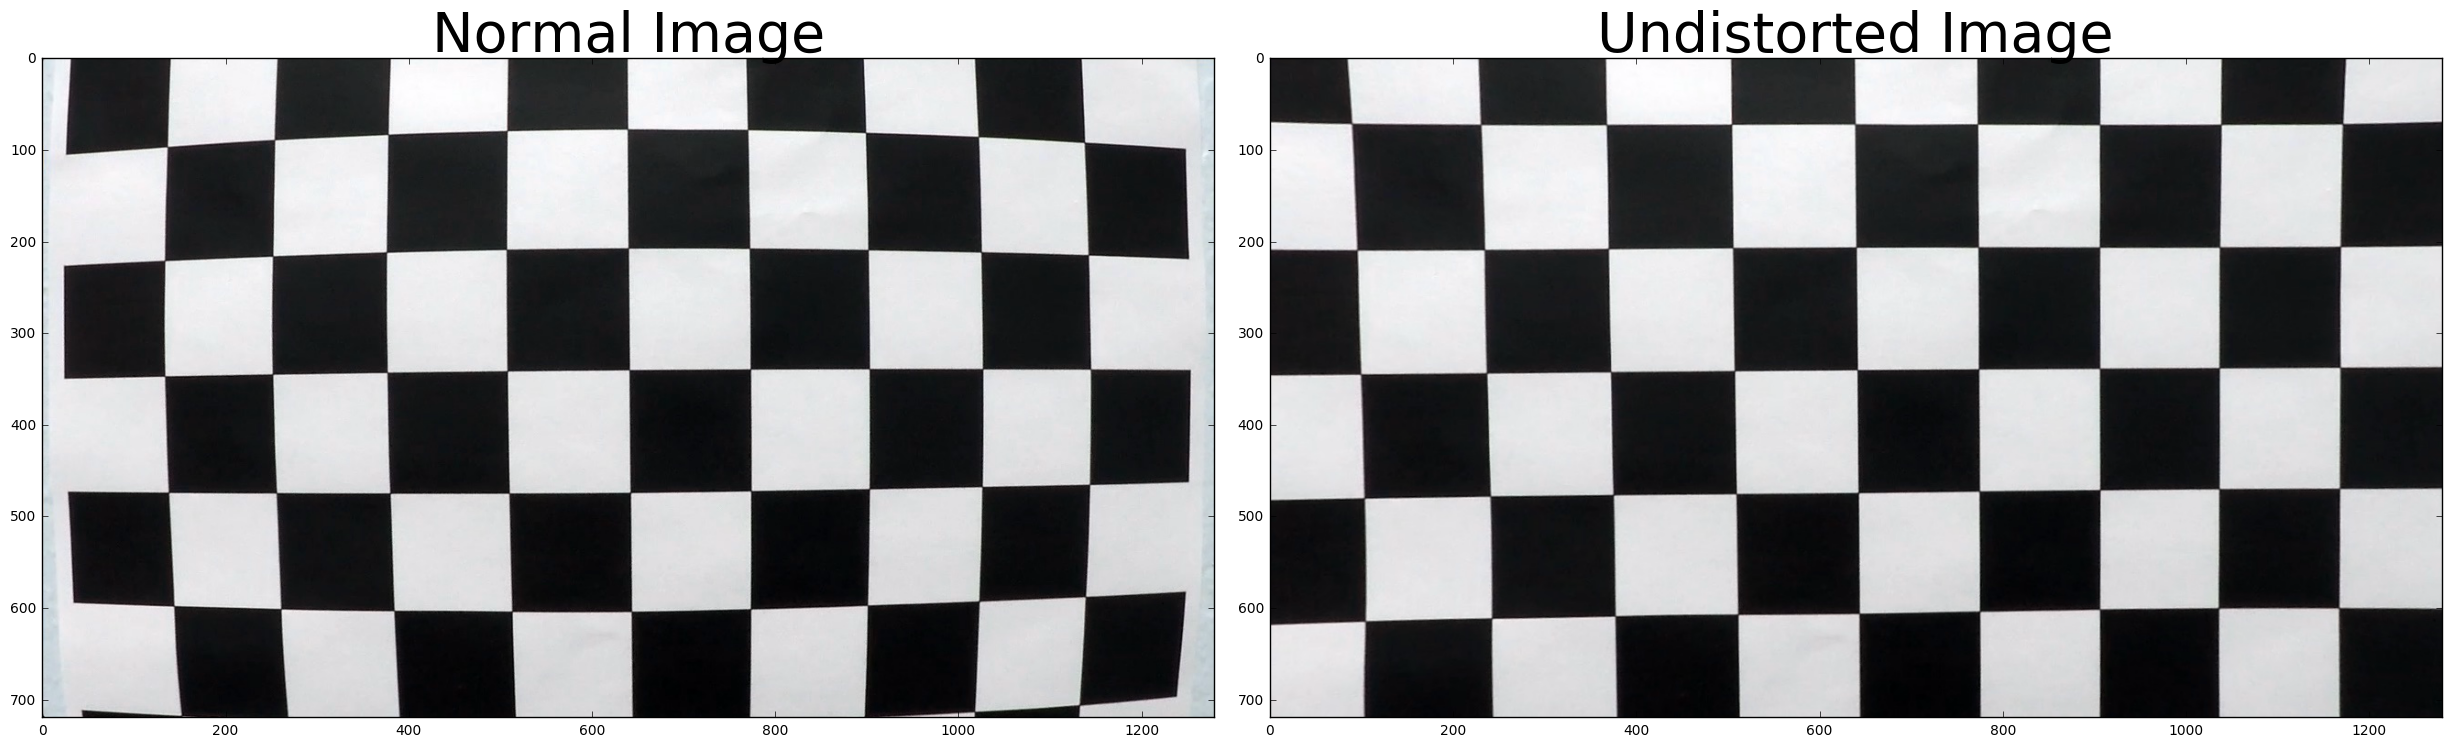

In [4]:
# input a image
# output undistorted image
def distortion_correction(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


# Apply distortion to all images
img = cv2.imread('camera_cal/calibration1.jpg')

img_before = np.copy(img)

# returns our undistorted image
undist = distortion_correction(img, mtx, dist)

# save the image
fname = "camera_cal/undistorted_1.jpg"
cv2.imwrite(fname, undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

ax2.set_title('Undistorted Image', fontsize=40)
ax2.imshow(undist)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print("distortion corrected!")

## Warping an image to change perspective.

We're now going to try adjusting our image to get a clear birds eye view.


loaded


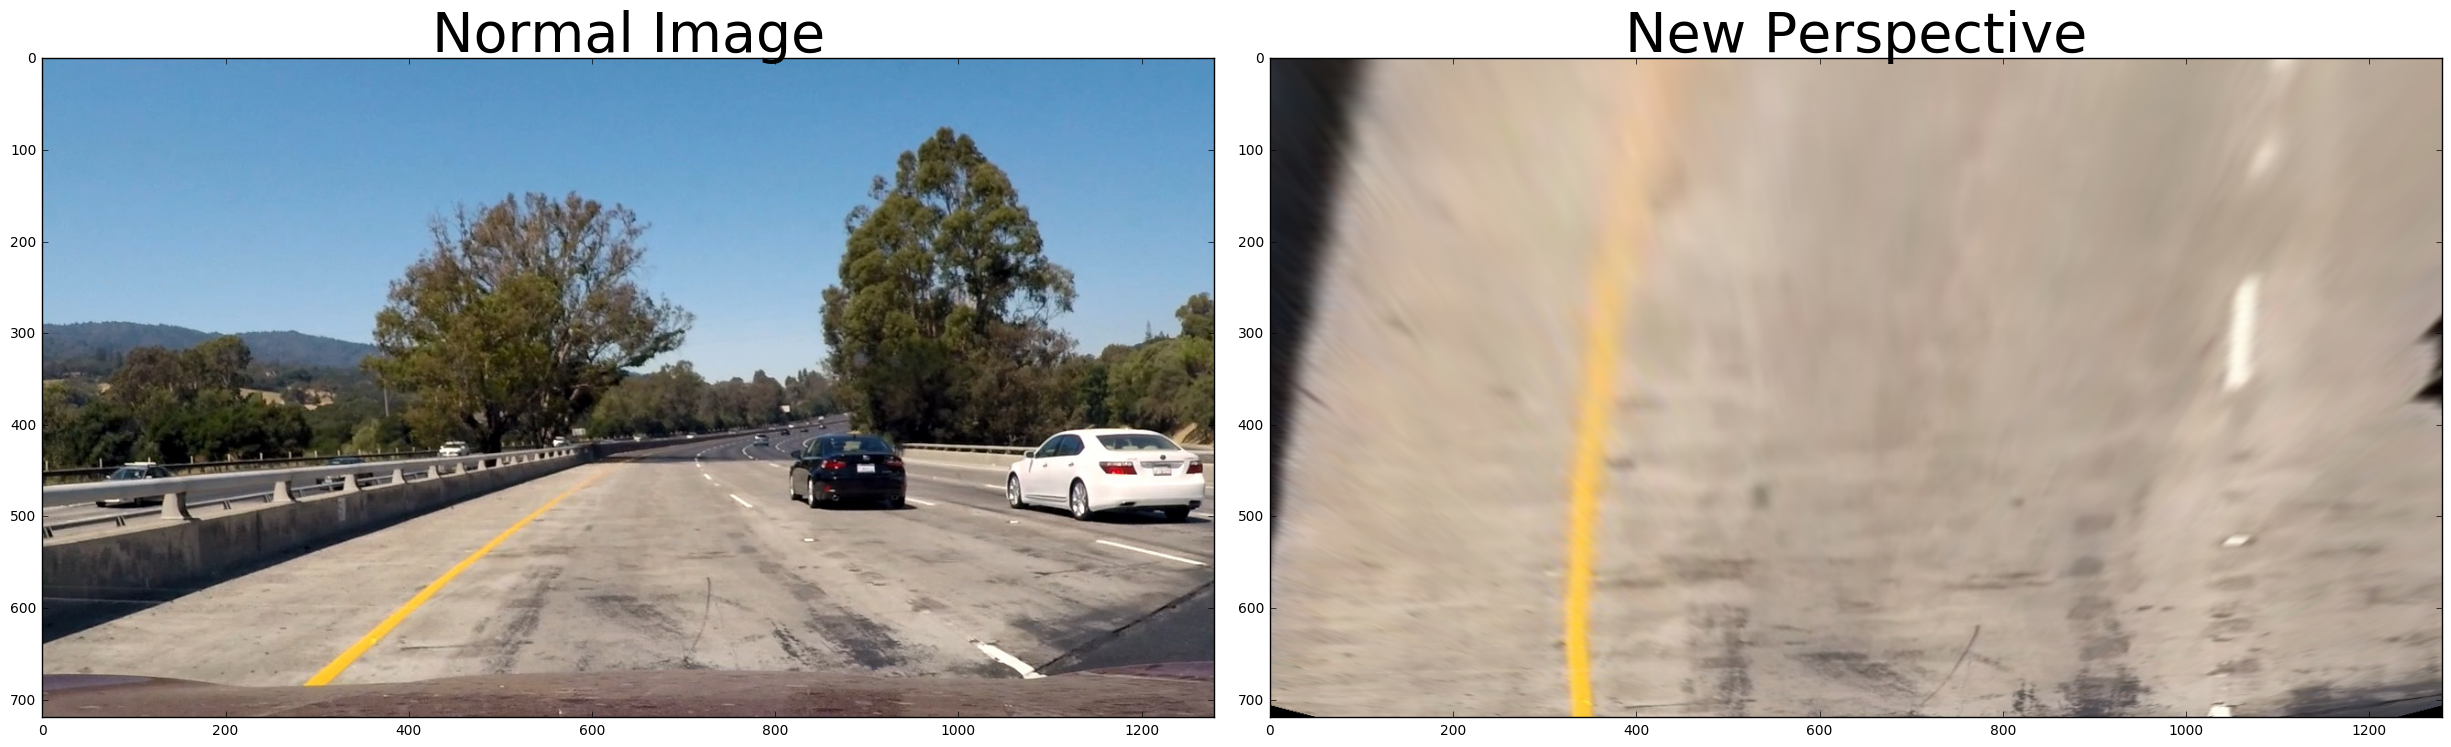

In [5]:
# input a color or gray scale image of the road (1280*720)
# output the bird_view the road, for finding lane line
# if reverse = True, it converts bird view image back to original perspective
def warper(img, reverse = False):
    xsize = img.shape[1]
    ysize = img.shape[0]
    
    # set up box boundary
    xmid = xsize/2 # middle point
    upper_margin = 85  # upper width
    lower_margin = 490 # lower width
    upper_bound  = 460 # upper value of y
    lower_bound  = 670 # bottom value of y
    dst_margin   = 450 # bird view width
    
    # source points
    p1_src = [xmid - lower_margin, lower_bound]
    p2_src = [xmid - upper_margin, upper_bound]
    p3_src = [xmid + upper_margin, upper_bound]
    p4_src = [xmid + lower_margin,lower_bound]
    src = np.array([p1_src, p2_src, p3_src, p4_src], dtype=np.float32)
    
    # distination points
    p1_dst = [xmid - dst_margin, ysize]
    p2_dst = [xmid - dst_margin, 0]
    p3_dst = [xmid + dst_margin, 0]
    p4_dst = [xmid + dst_margin, ysize]
    dst = np.array([p1_dst, p2_dst, p3_dst, p4_dst], dtype=np.float32)
    
    if(not reverse):
        # if we need to change to bird view 
        # given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        # else switch src and dst, change back from bird view
        M = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)
    return warped


# demonstrate perspective change
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img_before = np.copy(img)

# returns our undistorted image
img = distortion_correction(img, mtx, dist)
# shift perspective on the image
img_after = warper(img)

# save the image
# fname = "camera_cal/birds_eye_1.jpg"
# cv2.imwrite(fname, top_perspective)


# show the difference on our sample image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

ax2.set_title('New Perspective', fontsize=40)
ax2.imshow(img_after)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


print("loaded")

## Creating our thresholded binary image. 

Now that we can change perspective and adjust for distortion, let's work on creating an image that will allow us to find the lines we're interested in along this new perspective of the road. 

HLS color space is much more convenient because we can use it to determine the saturation of color in an image giving us a more reliable metric of color saturation than we would have if we were only looking at concentrations of Red, Blue, or Green. 


We'll use a combination of gradients using sobel operators as well as HSV transforms to create a binary image where only color gradients above a certain threshold are colored white. 

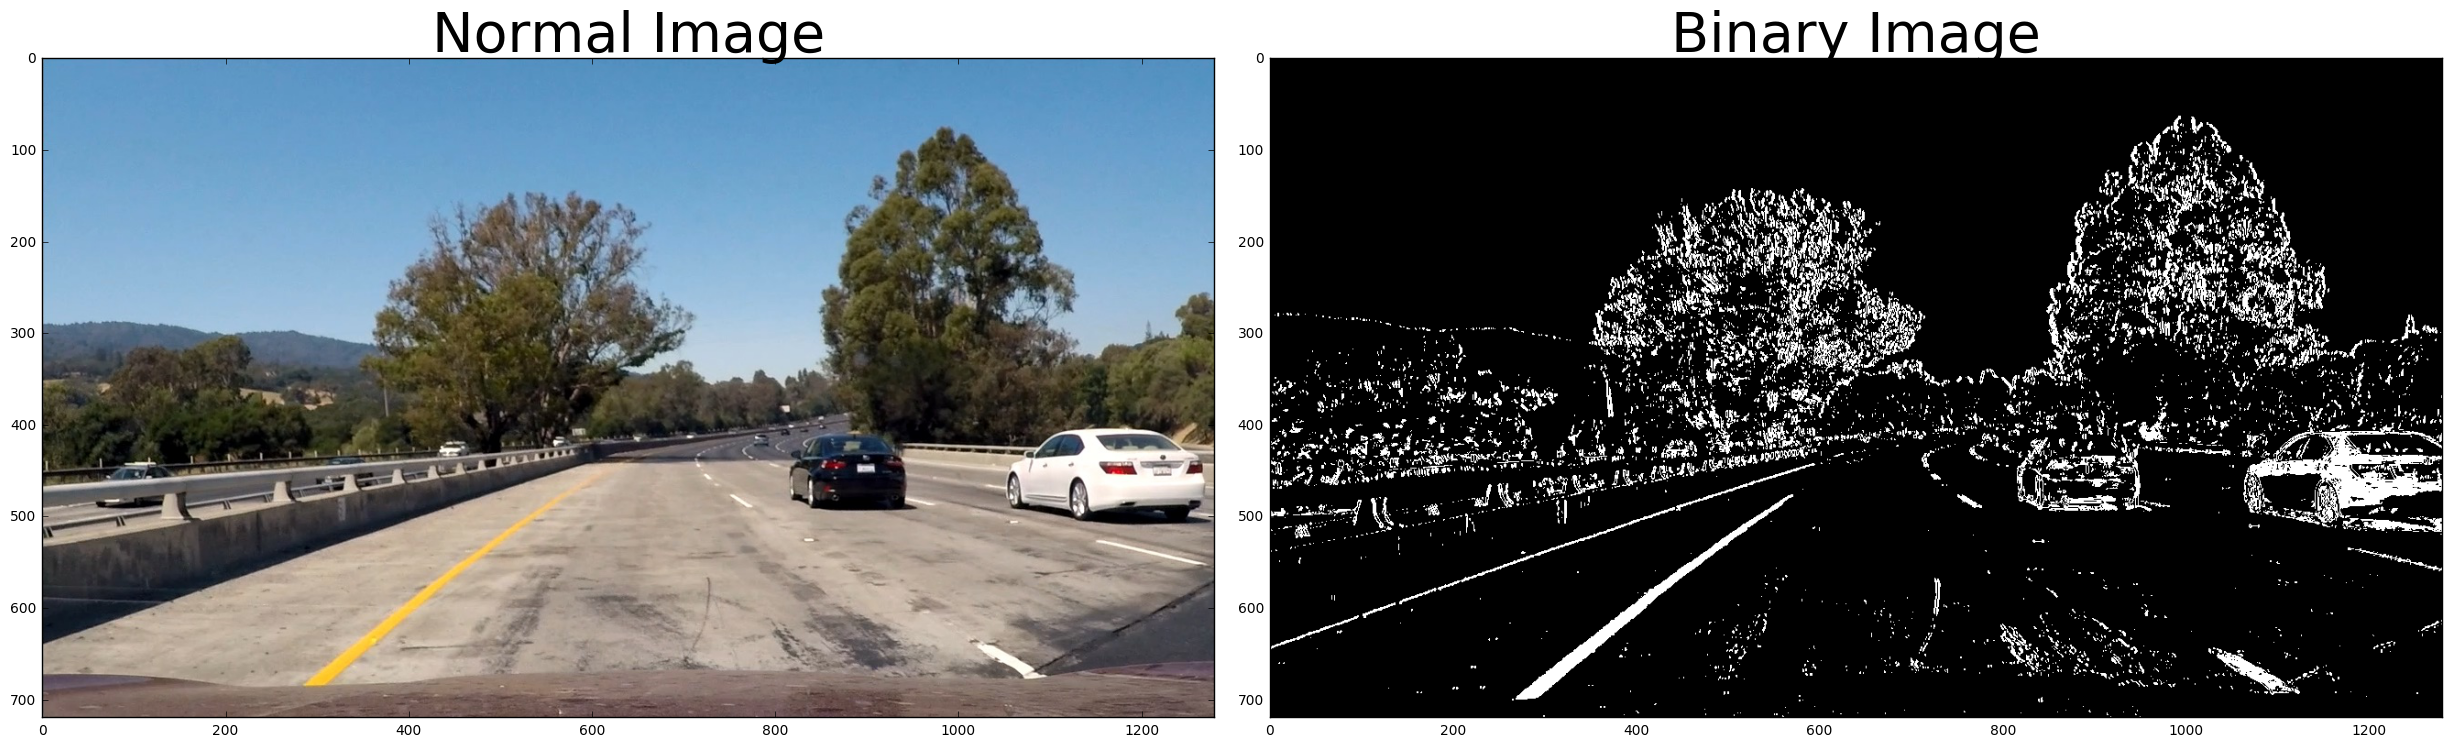

In [6]:
# applying sobel operators and HSV color transforms.
def combined_binary(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_before = np.copy(img)

img = distortion_correction(img, mtx, dist)
img_after = combined_binary(img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# left graph
ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

# right graph of colored image
ax2.set_title('Binary Image', fontsize=40)
ax2.imshow(img_after, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Putting the pieces together

We can now create binary images and we can shift perspective as well, let's take a look at how this looks when combining them. 

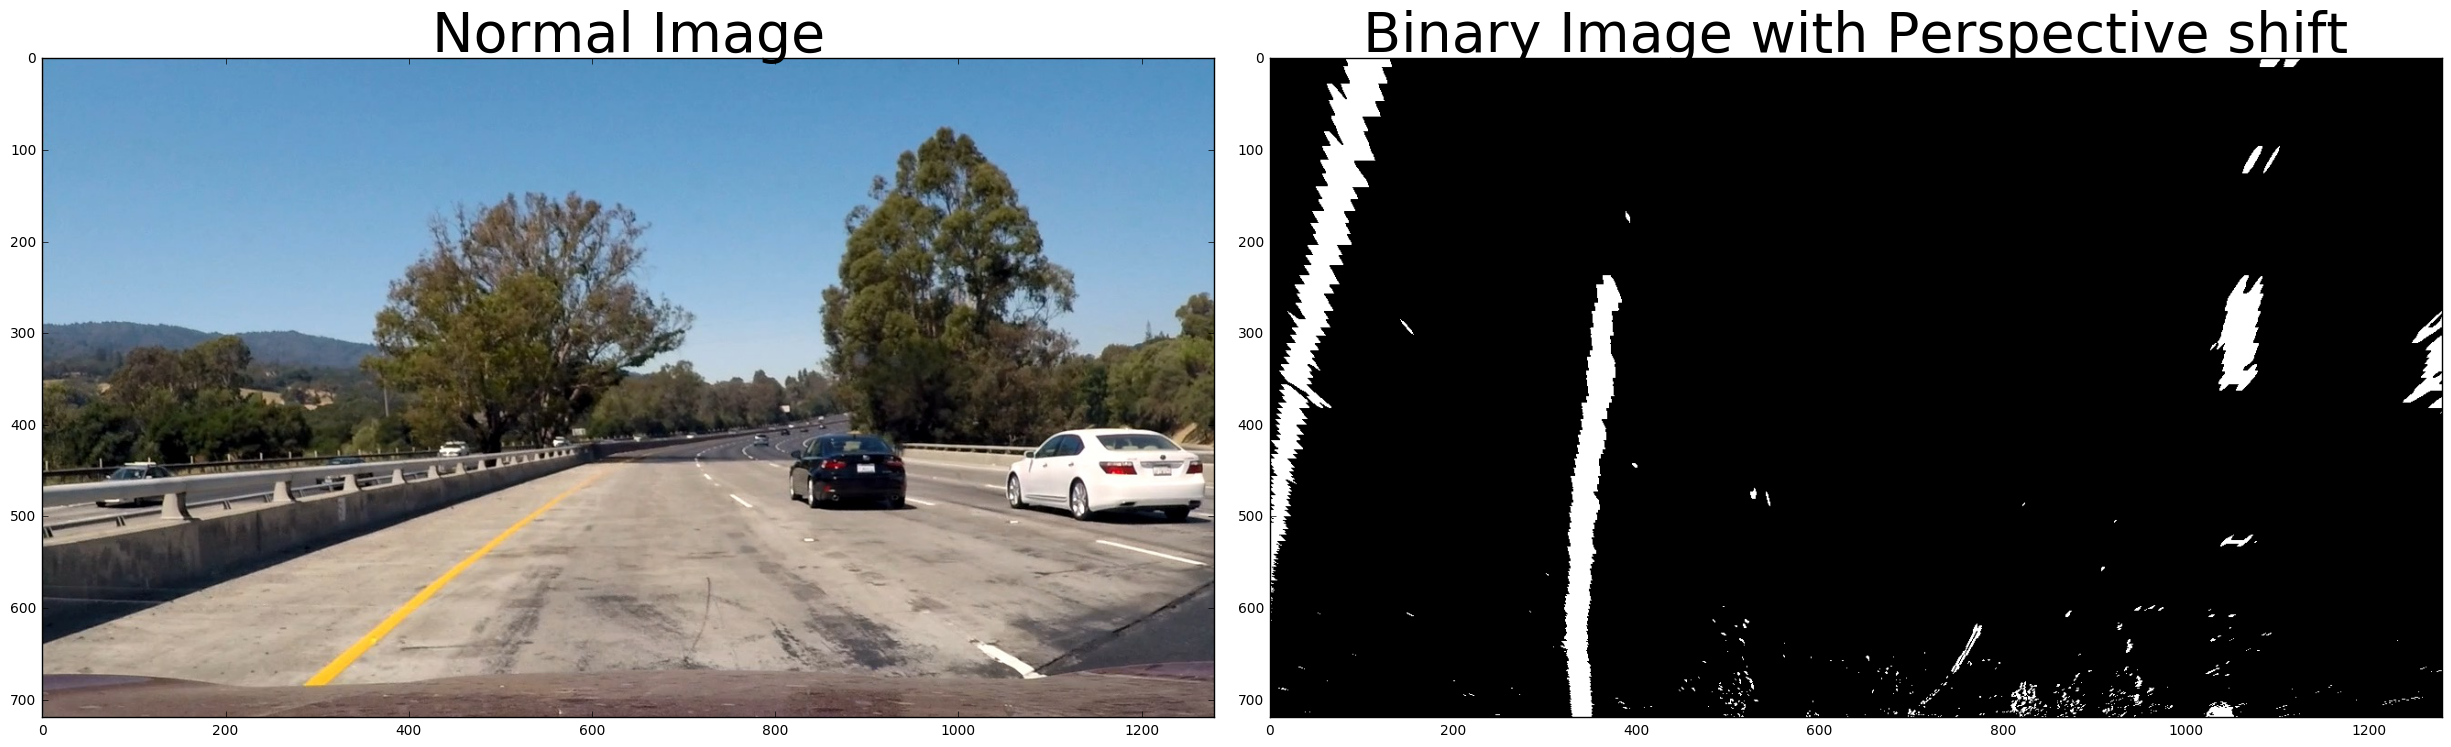

In [7]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_before = np.copy(img)

img = distortion_correction(img, mtx, dist)
img = combined_binary(img)
img_after = warper(img)

## plotting images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# left graph
ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

# right graph of colored image
ax2.set_title('Binary Image with Perspective shift', fontsize=40)
ax2.imshow(img_after, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Determining the right and left lanes.

Now we have a very robust way of finding high contrast gradients in our images and we can go on to start marking our lane lines. The next question to solve is where are the actual lanes in this image we're looking at? 


So let's use the recommended algorithm of simply taking a histogram in the number of non-zero pixels along the horizontal axis. 


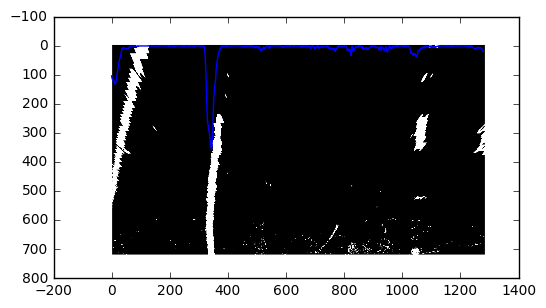

In [8]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = warper(combined_binary(img))
histogram = np.sum(img[floor(img.shape[0]/2):,:], axis=0)

plt.imshow(img, cmap="gray")
plt.plot(histogram)

#### We can clearly see the spike in the left lane here, but given that this histogram is taken as the sum from the bottom half of the image and downwards, you can see the smaller spike caused by the right lane, but it's not very pronounced here.


## Identifying and Polynomial Curve Fitting of the Lane Lines

Unlike the last project, this time we're going to use polynomial curves to fit them instead of lines which should give us better results.

Those polynomials will be in the form $f(y) = Ay^2 + By + C $


(720, 0)

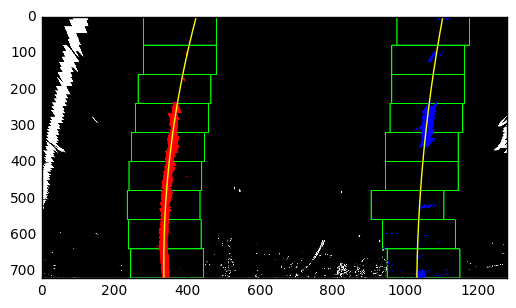

In [9]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img = combined_binary(img)
binary_warped = warper(img)


# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) # EDITED
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2) ## EDITED
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)




## Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Bam.

We now have our two lane lines!

We also have polynomials that can accurately fit those lines, Now we can use these polynomials to find the curvature of the roads that these cars would be driving along. 

## Finding Radius of curvature

$$ R_{curvature}   = \frac{ [ 1 + { (\frac{dy}{dx}})^2 ]^{\frac{3}{2}}  }  {  \frac{d^2 y}{d x^2} } $$

image center :  640
lane center :  551.639092566
offset :  88.36090743433715


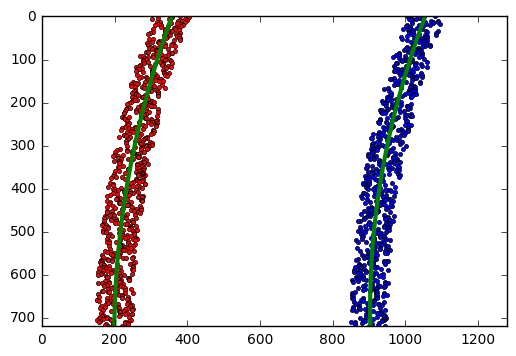

In [10]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# calculate lane separation and separation from center of vehicle
left_lane_lower = left_fit[0]* 719.0**2 + left_fit[1]*719.0 + left_fit[2]
right_lane_lower = right_fit[0]* 719.0**2 + right_fit[1]*719.0 + right_fit[2]

image_center = img.shape[1] // 2
lane_center = ((left_lane_lower + right_lane_lower) / 2 )
offset = fabs(image_center - lane_center)

# print(left_lane_lower, right_lane_lower)

print("image center : ", image_center )
print("lane center : ", lane_center ) 
print("offset : ", offset )

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o',  color='red',  markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

#### We've plotted our additional sample data based on our polynomials and we can now find our radius of curvature. 


In [11]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1732.89388624 1518.6361816


#### These values however have been calculated in Pixel space, but we can convert it into real world units to make sure our values make sense.

In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x, y in world space
left_fit_cr  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters!
print(left_curverad, 'm', right_curverad, 'm')

569.046690927 m 498.2586129 m


### We can see our computed curvature for this road does seem accurate when compared to the numbers on a typical american road. 

See [here](http://onlinemanuals.txdot.gov/txdotmanuals/rdw/Table_2-3_m.pdf) for the metric numbers. 


### Calculating our offset from the center of the lane. 

If we assume the camera is mounted at the center of the car, such that the center of the car is the midpoint at the bottom of the image, the center of the lane should be between the two lines detected; 

We can calculate the distance between the center of the image and the center of the lanes; That way we can always work to keep this offset from the middle of the lane as close to zero as possible.




## Some cleaning. 

Before we go on to apply all of this unto a video can benefit from cleaning up most of the ideas we've expressed here so far and crating a Line class to store most of our information. That way we can have an easier time with writing our code so that calculating our offsets isn't so painful. 

We introduce the Python `Line` class to simplify this a bit.

In [13]:
# defining our line class
class Line():
    def __init__(self):
        # have we seen this lane before? 
        self.detected = False
        
        # previous n lines
        self.recent_left_fit  = []
        self.recent_right_fit = []
        
        # coefficients of the most recent fit
        self.current_left_fit  = [np.array([False])]
        self.current_right_fit = [np.array([False])]
    
    # get the best coefficients, average the last 3
    def average_fit(self):
        cur_left_fit  = np.average(self.recent_left_fit[-3:], axis=0)
        cur_right_fit = np.average(self.recent_right_fit[-3:], axis=0)
        return cur_left_fit, cur_right_fit
    
    # calculate the offset based on the lines
    # Attempt to confirm that the center of the lanes is in the center of the image. 
    def find_offset(self):
        left_fit, right_fit = self.average_fit()
        base       = 719      # given in lesson
        middle     = 1279/2 # middle of the image
        xm_per_pix = 3.7/650 # meters per pixel in x dimension, given in the lesson
        left_base  = left_fit[0]*base**2 + left_fit[1]*base + left_fit[2]
        right_base = right_fit[0]*base**2 + right_fit[1]*base + right_fit[2]
        offset  = ((right_base - left_base) - middle) * xm_per_pix
        return offset

    # return curvature based on method given in lesson.
    def find_curvature(self):
        left_fit, right_fit = self.average_fit()
        
        # Generate some fake data to represent lane-line pixels
        ploty = np.linspace(0, 719, num=720) # cover same range as the image

        # arbitrary quadratic coefficient
        l_quadratic_coeff = left_fit[0] 
        r_quadratic_coeff = right_fit[0]
        
        # For each y position generate random x position within +/-50 pix
        # of the line base position in each case (x=200 for left, and x=900 for right)
        leftx = np.array([200 + (y**2)*l_quadratic_coeff + np.random.randint(-50, high=51) 
                                      for y in ploty])
        rightx = np.array([900 + (y**2)*r_quadratic_coeff + np.random.randint(-50, high=51) 
                                        for y in ploty])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        # Fit a second order polynomial to pixel positions in each fake lane line
        
        # fit to the left line
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
        # fit to the right line
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Define y value where we want radius of curvature
        # in this case we'll use the max y value for the bottom of the image.
        y_eval = np.max(ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 /720 # meters per pixel in y dimension
        xm_per_pix = 3.7/650 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature (in meters)
        left_curverad  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        return left_curverad, right_curverad


    def find_lane(self, warped):
        if(not self.detected):
            # do our bad search if we've never seen the lines before
            detect = self.blind_search(warped)
        else:
            # do our better search based on what we already know. 
            detect = self.margin_search(warped)
            
        left_fit = self.current_left_fit 
        right_fit = self.current_right_fit
        
        # sanity check pipeline
        # check base distance
        base = 720
        left_base = left_fit[0]*base**2 + left_fit[1]*base + left_fit[2]
        right_base = right_fit[0]*base**2 + right_fit[1]*base + right_fit[2]
        
        if(right_base < left_base or np.absolute((right_base - left_base) - 650) >= 200):
            detect = False
        
        # check derivative difference
        if(np.absolute((2*left_fit[0]+left_fit[1]) - (2*right_fit[0]+right_fit[1])) >= 0.8):
            detect = False
        
        # force to append the first few detection    
        if(len(self.recent_left_fit) < 3 or len(self.recent_right_fit) < 3):
            detect = False
            self.recent_left_fit.append(left_fit)
            self.recent_right_fit.append(right_fit)
        
        # if it is a real dection, we add to recent detection
        if(detect):
            self.detected = True
            self.recent_left_fit.append(left_fit)
            self.recent_right_fit.append(right_fit)
        else:
            self.detected = False

    # use moving histograms to search for new lines
    def blind_search(self, warped):
        # Assuming you have created a warped binary image called "binary_warped"
        binary_warped = np.sum(warped, axis=2) # collapse 3 channel into 1
        binary_y = warped[:,:,0]
        binary_w = warped[:,:,1]
        
        # Take a histogram of the bottom half of the image
        histogram_l = np.sum(binary_y[floor(binary_y.shape[0]/2):,:], axis=0)
        histogram_r = np.sum(binary_w[floor(binary_w.shape[0]/2):,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint    = np.int(floor(histogram_l.shape[0]/2))
        leftx_base  = np.argmax(histogram_l[:midpoint])
        rightx_base = np.argmax(histogram_r[midpoint:]) + midpoint
        
        nwindows = 9
        margin = 100
        minpix = 50
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero_l = binary_y.nonzero()
        nonzeroy_l = np.array(nonzero_l[0])
        nonzerox_l = np.array(nonzero_l[1])
        
        nonzero_r = binary_w.nonzero()
        nonzeroy_r = np.array(nonzero_r[0])
        nonzerox_r = np.array(nonzero_r[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds  = []
        right_lane_inds = []
        leftx           = []
        lefty           = []
        rightx          = []
        righty          = []
        
        # points of current fit
        cur_left_fit, cur_right_fit = self.average_fit()

        # Step through the windows one by one
        for window in range(nwindows):
            # find windows bounds in x and y (and right and left)
            win_y_low       = binary_warped.shape[0] - (window+1)*window_height
            win_y_high      = binary_warped.shape[0] - window*window_height
            win_xleft_low   = leftx_current - margin
            win_xleft_high  = leftx_current + margin
            win_xright_low  = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(warped,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(warped,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds  = ((nonzeroy_l >= win_y_low) & (nonzeroy_l < win_y_high) & (nonzerox_l >= win_xleft_low)  & (nonzerox_l < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy_r >= win_y_low) & (nonzeroy_r < win_y_high) & (nonzerox_r >= win_xright_low) & (nonzerox_r < win_xright_high)).nonzero()[0]
                        
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if(len(good_left_inds) > minpix):
                leftx_current = np.int(np.mean(nonzerox_l[good_left_inds]))
            if(len(good_right_inds) > minpix):        
                rightx_current = np.int(np.mean(nonzerox_r[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds  = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox_l[left_lane_inds]
        lefty = nonzeroy_l[left_lane_inds]

        rightx = nonzerox_r[right_lane_inds]
        righty = nonzeroy_r[right_lane_inds]

        detect = True
        if(len(leftx) > 1000 or len(self.recent_left_fit) < 1):
            self.current_left_fit = np.polyfit(lefty, leftx, 2)
            
        else: # not enough point to suggest a good fit, use last fit
            print("left blind search fail")
            self.current_left_fit = cur_left_fit
            detect = False
            
        if(len(rightx) > 1000 or len(self.recent_right_fit) < 1):
            self.current_right_fit = np.polyfit(righty, rightx, 2)
        else:
            # not enough point to suggest a good fit, use last fit
            print("right blind search fail")
            self.current_right_fit = cur_right_fit
            detect = False
        return detect


    # use best fit coefficients to restrict search area within margin
    def margin_search(self, warped):

        # Assuming you have created a warped binary image called "binary_warped"
        binary_warped = np.sum(warped, axis=2) # collapse 3 channel into 1
        binary_y = warped[:,:,0]
        binary_w = warped[:,:,1]

        nwindows = 9
        margin = 100
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        maxpix = 6000

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero_l  = binary_y.nonzero()
        nonzeroy_l = np.array(nonzero_l[0])
        nonzerox_l = np.array(nonzero_l[1])
        
        nonzero_r  = binary_w.nonzero()
        nonzeroy_r = np.array(nonzero_r[0])
        nonzerox_r = np.array(nonzero_r[1])
        
        leftx = []
        lefty = []
        rightx = []
        righty =  []
        
        # points of current fit
        cur_left_fit, cur_right_fit = self.average_fit()
        yvals = np.linspace(0, 719, num=720, dtype=np.int32)# to cover same y-range as image
        l_xvals = []
        r_xvals = []
        for y in yvals:
            l_xvals.append(cur_left_fit[0]*y**2 + cur_left_fit[1]*y + cur_left_fit[2] + np.random.randint(-50, high=51))
            r_xvals.append(cur_right_fit[0]*y**2 + cur_right_fit[1]*y + cur_right_fit[2] + np.random.randint(-50, high=51))
        l_xvals = np.array(l_xvals, dtype=np.int32)
        r_xvals = np.array(r_xvals, dtype=np.int32)  
        # Step through the windows one by one
        l_base_missing = 0
        r_base_missing = 0
        
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            
            leftx_current = np.int(cur_left_fit[0]*win_y_high**2 + cur_left_fit[1]*win_y_high + cur_left_fit[2])
            rightx_current = np.int(cur_right_fit[0]*win_y_high**2 + cur_right_fit[1]*win_y_high + cur_right_fit[2])

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(warped,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
            cv2.rectangle(warped,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy_l >= win_y_low) & (nonzeroy_l < win_y_high) & (nonzerox_l >= win_xleft_low) & (nonzerox_l < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy_r >= win_y_low) & (nonzeroy_r < win_y_high) & (nonzerox_r >= win_xright_low) & (nonzerox_r < win_xright_high)).nonzero()[0]
            
            # check left side
            # if the number of points within a reasonable range, it suggest a good detection
            # too less or too much points suggest noise
            if((len(good_left_inds) > minpix) and (len(good_left_inds) < maxpix)):
                leftx.append(nonzerox_l[good_left_inds])
                lefty.append(nonzeroy_l[good_left_inds])
            else:
            # use last fit to generate fake points
            # means when fail to search in this window, 
            # we guess it should have lane line similar to last detection within the same window position
                good_left_inds = ((yvals >= win_y_low) & (yvals < win_y_high) & (l_xvals >= win_xleft_low) & (l_xvals < win_xleft_high)).nonzero()[0]
                if(window <= 4):
                    l_base_missing = l_base_missing + 1
                    leftx.append(l_xvals[good_left_inds])
                    lefty.append(yvals[good_left_inds])
                    # if use fake data, we plot it
                    for p in good_left_inds:
                        cv2.circle(warped, (l_xvals[p], yvals[p]), 3, (0, 255 ,255))
                elif(l_base_missing >= 1):
                    leftx.append(l_xvals[good_left_inds])
                    lefty.append(yvals[good_left_inds])
                    # if use fake data, we plot it
                    for p in good_left_inds:
                        cv2.circle(warped, (l_xvals[p], yvals[p]), 3, (0, 255 ,255))
                        
            # check right side
            # same idea as checking left side
            if((len(good_right_inds) > minpix) and (len(good_right_inds) <= maxpix)):
                rightx.append(nonzerox_r[good_right_inds])
                righty.append(nonzeroy_r[good_right_inds])
            else:
                good_right_inds = ((yvals >= win_y_low) & (yvals < win_y_high) & (r_xvals >= win_xright_low) & (r_xvals < win_xright_high)).nonzero()[0]
                if(window <= 4):
                    r_base_missing = r_base_missing + 1
                    rightx.append(r_xvals[good_right_inds])
                    righty.append(yvals[good_right_inds])
                    for p in good_right_inds:
                        cv2.circle(warped, (r_xvals[p], yvals[p]), 5,(0, 0 ,255))
                elif(r_base_missing >= 1):
                    rightx.append(r_xvals[good_right_inds])
                    righty.append(yvals[good_right_inds])
                    for p in good_right_inds:
                        cv2.circle(warped, (r_xvals[p], yvals[p]), 5,(0, 0 ,255))
        
        leftx = np.concatenate(leftx)
        lefty = np.concatenate(lefty)
        self.current_left_fit = np.polyfit(lefty, leftx, 2)

        rightx = np.concatenate(rightx)
        righty = np.concatenate(righty)
        self.current_right_fit = np.polyfit(righty, rightx, 2)
        
        return True    

print('Class loaded')

Class loaded


### We'll also add a couple of utility functions dealing with our lane lines.


In [14]:
def draw_lane(undist, warped, stack, left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    warped_mask = warped.copy()
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(stack[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 0, 255))
    cv2.polylines(stack, np.int_([pts]), True, (255,255,255), 5)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warper(color_warp, reverse = True)
    
    # Combine the result with the original image
    warped_mask = cv2.addWeighted(warped_mask, 1, color_warp, 0.3, 0)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result, warped_mask


# find white lane lines
def find_white_lanes(img):
    img = np.copy(img)
    # convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # 3 different threshold for different lighting condition
    
    # high light , color = B, used in normal light condition
    lower_1 = np.array([0, 0, 200])
    upper_1 = np.array([255, 25, 255])
    
    # high light , color = G, not used, saved for future experiment
    lower_2 = np.array([0, 0, 200])
    upper_2 = np.array([255, 25, 255])
    
    # low h low s low v , color = R, used in low light condition
    lower_3 = np.array([0, 0, 170])
    upper_3 = np.array([255, 20, 190])

    white_1 = cv2.inRange(hsv, lower_1, upper_1)
    white_2 = cv2.inRange(hsv, lower_2, upper_2)
    white_3 = cv2.inRange(hsv, lower_3, upper_3)

    if(len(white_1.nonzero()[0]) > 4000):
        white_3 = np.zeros_like(white_1)
    
    if(len(white_2.nonzero()[0]) > 40000): # too much false detection
        white_2 = np.zeros_like(white_1)
        
    if(len(white_3.nonzero()[0]) > 40000): # too much false detection
        white_3 = np.zeros_like(white_1)
    
    return white_1, white_2, white_3


# find yellow lane lines
def find_yellow_lanes(img):
    img = np.copy(img)
    # convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float) 
    
    # color = B, high s high v, used in normal light condition
    lower_1 = np.array([ 0, 100, 100])
    upper_1 = np.array([ 50, 255, 255])
    
    # color = G, low s low v, used in low light condition
    lower_2 = np.array([ 10, 35, 100])
    upper_2 = np.array([ 40, 80, 180])
    
    # color = R, low s high v, used in extreme high light condition
    lower_3 = np.array([ 15, 30, 150])
    upper_3 = np.array([ 45, 80, 255])
    
    yellow_1 = cv2.inRange(hsv, lower_1, upper_1)
    yellow_2 = cv2.inRange(hsv, lower_2, upper_2)
    yellow_3 = cv2.inRange(hsv, lower_3, upper_3)

    if(len(yellow_1.nonzero()[0]) > 30000):
        yellow_2 = np.zeros_like(yellow_1)
        yellow_3 = np.zeros_like(yellow_1)
        
    if(len(yellow_2.nonzero()[0]) > 30000):
        yellow_2 = np.zeros_like(yellow_1)
        
    if(len(yellow_3.nonzero()[0]) > 30000):
        yellow_3 = np.zeros_like(yellow_1)

    return yellow_1, yellow_2, yellow_3


## full pipeline function
def final_pipeline(img):
    global tracker
    global frame_id
    frame_id = frame_id + 1
    
    # image is input in RGB format from moviepy
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # undistort the image
    undist = distortion_correction(img, mtx, dist)
    
    # warp to bird view
    warped  = warper(undist, reverse = False)
    
    # find yellow and white lane line
    # and map to binary image
    yellow_1, yellow_2, yellow_3 = find_yellow_lanes(warped)
    white_1, white_2, white_3    = find_white_lanes(warped)
    
    w = np.zeros_like(white_1)
    w[(white_1 > 0) | (white_2 > 0) | (white_3 > 0)] = 255
    
    y = np.zeros_like(yellow_1)
    y[(yellow_1 > 0) | (yellow_2 > 0 ) | (yellow_3 > 0 )] = 255
    
    # stack yellow and white lane line into one image
    stack = np.zeros_like(img)
    stack[:,:,0] = y
    stack[:,:,1] = w
    
    # find lane lines
    tracker.find_lane(stack)
    
    # get best fitting coefficents
    left_fit, right_fit = tracker.average_fit()
    
    # draw the road mask
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    result, warped_mask = draw_lane(undist, warped, stack, left_fit, right_fit)
    
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    
    # get statistics
    left_curverad, right_curverad = tracker.find_curvature()
    offset = tracker.find_offset()
    
    # round our numbers for the display purposes 
    left_curverad  = round(left_curverad, 2)
    right_curverad = round(right_curverad, 2)
    offset      = round(float(offset), 2)

    
    # text font and color in video
    text_font   = cv2.FONT_HERSHEY_SIMPLEX
    text_color  = (255, 255, 255) # white for overwriting video
    
    text_panel = np.zeros((240, 640, 3), dtype=np.uint8)
    
    # frame id
    cv2.putText(text_panel, "Frame id:     " + str(frame_id),
                (30, 40), text_font, 1, text_color, 2)
    
    # left curve radius
    cv2.putText(text_panel, 
                "Left Curve Radius: " + str(left_curverad)+"m",
                (30, 80), text_font, 1, text_color, 2)
    
    # right curve radius
    cv2.putText(text_panel, 
                "Right Curve Radius: " + str(right_curverad)+"m",
                (30, 120), text_font, 1, text_color, 2)

    # middle panel radius
    cv2.putText(text_panel, 
                "Center Offset:" + str(offset)+"m", 
                (30, 160), text_font, 1, text_color, 2)
    
    diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)

    original_mask = result
    warped        = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA)   
    warped_plot   = cv2.resize(stack,  (320,240), interpolation=cv2.INTER_AREA)
    warped_mask   = cv2.resize(warped_mask, (640,480), interpolation=cv2.INTER_AREA)

    # render original video with lane segment drawn in 
    diagScreen[0:720, 0:1280]      = result
    diagScreen[0:480, 1280:1920]   = warped_mask    
    diagScreen[480:720, 1600:1920] = warped_plot
    diagScreen[480:720, 1280:1600] = warped
    diagScreen[720:960, 1280:1920] = text_panel
    
    return diagScreen

print("functions loaded")

functions loaded


### Now that we've cleaned it up, we'll put together the work we've done so far to demonstrate our results measuring curvature of the roads in the different perspectives that we're using, and then move on to apply this to our videos.


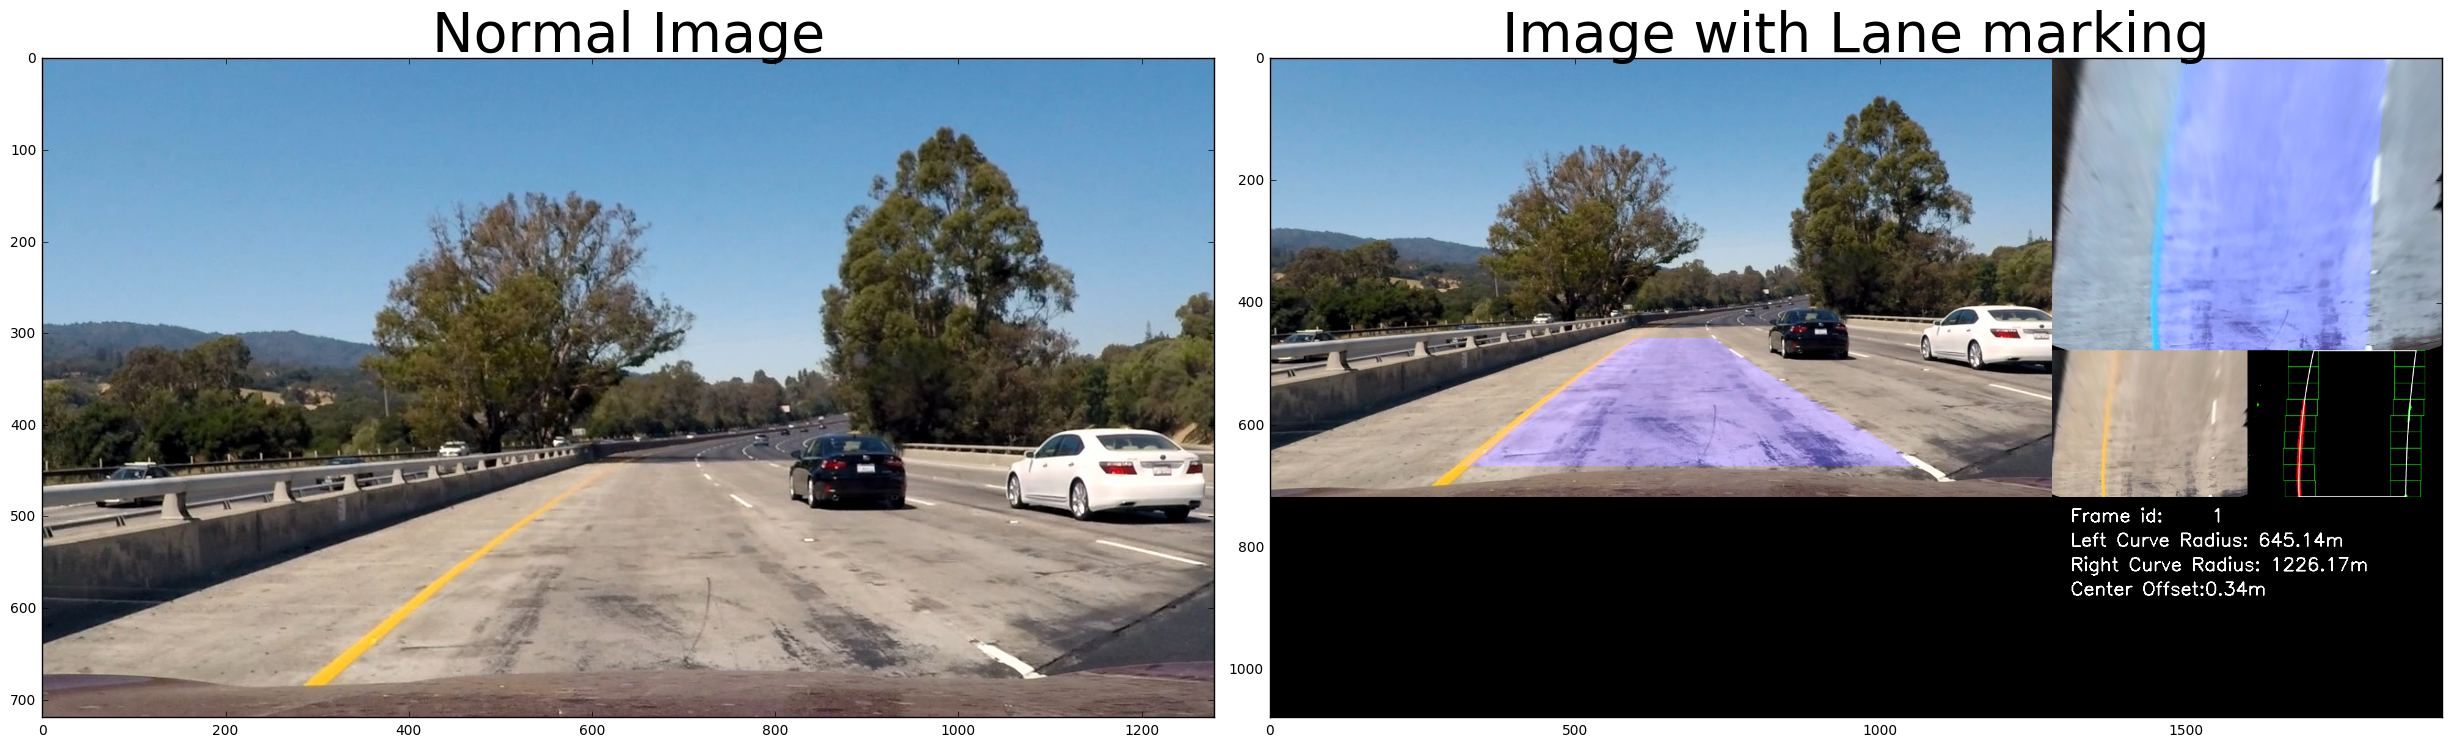

In [15]:
## image display purposes
img = cv2.imread('test_images/test1.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_before = np.copy(img)

# initial line object and frame_id
tracker = Line()
frame_id = 0

img_after = final_pipeline(img)

# plotting images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# left graph
ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

# right graph of colored image
ax2.set_title('Image with Lane marking', fontsize=40)
ax2.imshow(img_after)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Now we can apply this to all of our images


In [16]:
# test case
images = glob.glob('test_images/test*.jpg')
for num, fname in enumerate(images):
    tracker = Line()
    img = cv2.imread(fname)
    wname = "output_images/test_image_"+str(num+1)+".jpg"
    # undistortion
    undist = distortion_correction(img, mtx, dist)
    # warp to bird view
    warped  = warper(undist, reverse = False)
    
    # find yellow and white lane line
    # and map to binary image
    yellow_1, yellow_2, yellow_3 = find_yellow_lanes(warped)
    white_1, white_2, white_3    = find_white_lanes(warped)
    w = np.zeros_like(white_1)
    w[(white_1 > 0) | (white_2 > 0) | (white_3 > 0)] = 255
    
    y = np.zeros_like(yellow_1)
    y[(yellow_1 > 0) | (yellow_2 > 0 ) | (yellow_3 > 0 )] = 255
    
    # stack yellow and white lane line into one image
    stack = np.zeros_like(img)
    stack[:,:,0] = y
    stack[:,:,1] = w
    
    # find lane lines
    tracker.find_lane(stack)
    
    # get best fitting coefficents
    left_fit, right_fit = tracker.average_fit()
    
    # draw the road mask
    result, warped = draw_lane(undist, warped, stack, left_fit, right_fit)
    
    # get statistics
    left_curverad, right_curverad = tracker.find_curvature()
    offset = tracker.find_offset()
    
    print("Image %s processed" % num)
    cv2.imwrite(wname, result)
    
print("finish")

Image 0 processed
Image 1 processed
Image 2 processed
Image 3 processed
Image 4 processed
Image 5 processed
finish


## Now let's try it for the project video, and the challenges to see how well we do.  


In [18]:
# project video

# frame id
frame_id = 0

# read in the project video
input_video_filename = 'project_video.mp4'
output_video_filename = 'project_output.mp4'

clip = VideoFileClip(input_video_filename)
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)

%time clip.write_videofile(output_video_filename, audio=False)


[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [16:45<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [17:43<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 21min 14s, sys: 1min 40s, total: 22min 54s
Wall time: 17min 47s


In [19]:
output_video_filename = 'project_output.mp4'

HTML("""<h1> The project video </h1>
        <br>
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>""".format(output_video_filename))


In [20]:
## Challenge Video

# reset frame id
frame_id = 0

# read in the project video
input_video_filename = 'challenge_video.mp4'
output_video_filename = 'challenge_output.mp4'

clip = VideoFileClip(input_video_filename)
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)

%time clip.write_videofile(output_video_filename, audio=False)



[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [07:01<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [07:03<00:00,  1.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 8min 11s, sys: 42.9 s, total: 8min 54s
Wall time: 7min 7s


In [21]:
output_video_filename = 'challenge_output.mp4'
HTML("""<h1> The challenge video </h1>
        <br>
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>""".format(output_video_filename))

In [22]:
## harder challenge video


# reset frame id
frame_id = 0

# read in the project video
input_video_filename = 'harder_challenge_video.mp4'
output_video_filename = 'harder_challenge_output.mp4'

clip = VideoFileClip(input_video_filename)
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)



%time clip.write_videofile(output_video_filename, audio=False)


[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


 15%|█▌        | 185/1200 [02:45<15:02,  1.12it/s]

right blind search fail


 16%|█▌        | 186/1200 [02:46<14:54,  1.13it/s]

right blind search fail
left blind search fail
right blind search fail


 16%|█▌        | 188/1200 [02:48<15:45,  1.07it/s]

left blind search fail
right blind search fail


 16%|█▌        | 189/1200 [02:49<15:57,  1.06it/s]

left blind search fail


 16%|█▌        | 190/1200 [02:50<15:46,  1.07it/s]

left blind search fail


 16%|█▌        | 191/1200 [02:51<15:18,  1.10it/s]

left blind search fail


 16%|█▌        | 192/1200 [02:52<15:07,  1.11it/s]

left blind search fail
left blind search fail
right blind search fail


 16%|█▌        | 194/1200 [02:53<15:29,  1.08it/s]

right blind search fail


 16%|█▋        | 195/1200 [02:54<14:53,  1.12it/s]

right blind search fail


 16%|█▋        | 197/1200 [02:56<14:46,  1.13it/s]

right blind search fail


 21%|██        | 254/1200 [03:46<13:36,  1.16it/s]

right blind search fail


 21%|██▏       | 255/1200 [03:47<13:22,  1.18it/s]

right blind search fail


 21%|██▏       | 256/1200 [03:48<13:39,  1.15it/s]

right blind search fail


 21%|██▏       | 257/1200 [03:49<13:28,  1.17it/s]

right blind search fail


 22%|██▏       | 258/1200 [03:50<13:27,  1.17it/s]

right blind search fail
right blind search fail


 22%|██▏       | 259/1200 [03:51<14:27,  1.09it/s]

right blind search fail


 22%|██▏       | 261/1200 [03:53<16:17,  1.04s/it]

right blind search fail


 22%|██▏       | 262/1200 [03:54<15:04,  1.04it/s]

right blind search fail


 22%|██▏       | 263/1200 [03:55<15:01,  1.04it/s]

right blind search fail


 22%|██▏       | 264/1200 [03:56<14:56,  1.04it/s]

right blind search fail
right blind search fail


 22%|██▏       | 268/1200 [04:00<14:53,  1.04it/s]

right blind search fail


 22%|██▏       | 269/1200 [04:01<14:35,  1.06it/s]

right blind search fail


 22%|██▎       | 270/1200 [04:02<14:25,  1.07it/s]

right blind search fail


 23%|██▎       | 271/1200 [04:03<14:08,  1.09it/s]

right blind search fail


 23%|██▎       | 272/1200 [04:03<13:53,  1.11it/s]

right blind search fail


 23%|██▎       | 273/1200 [04:04<14:02,  1.10it/s]

right blind search fail


 23%|██▎       | 274/1200 [04:05<14:14,  1.08it/s]

right blind search fail


 23%|██▎       | 275/1200 [04:06<14:07,  1.09it/s]

left blind search fail
right blind search fail


 23%|██▎       | 276/1200 [04:07<14:20,  1.07it/s]

left blind search fail
right blind search fail


 23%|██▎       | 277/1200 [04:08<14:20,  1.07it/s]

left blind search fail
right blind search fail


 23%|██▎       | 278/1200 [04:09<13:50,  1.11it/s]

left blind search fail
right blind search fail


 23%|██▎       | 279/1200 [04:10<13:38,  1.13it/s]

right blind search fail


 23%|██▎       | 280/1200 [04:11<13:36,  1.13it/s]

right blind search fail


 23%|██▎       | 281/1200 [04:11<13:11,  1.16it/s]

right blind search fail
right blind search fail


 24%|██▎       | 283/1200 [04:15<19:28,  1.27s/it]

right blind search fail


 25%|██▍       | 297/1200 [04:28<14:12,  1.06it/s]

right blind search fail


 36%|███▌      | 430/1200 [06:32<11:43,  1.09it/s]

left blind search fail


 36%|███▌      | 431/1200 [06:33<11:45,  1.09it/s]

left blind search fail
left blind search fail


 36%|███▌      | 433/1200 [06:35<12:15,  1.04it/s]

left blind search fail


 36%|███▌      | 434/1200 [06:36<11:56,  1.07it/s]

left blind search fail


 36%|███▋      | 435/1200 [06:37<11:26,  1.12it/s]

left blind search fail


 36%|███▋      | 436/1200 [06:38<11:23,  1.12it/s]

left blind search fail


 36%|███▋      | 437/1200 [06:39<11:49,  1.08it/s]

left blind search fail


 36%|███▋      | 438/1200 [06:40<11:53,  1.07it/s]

left blind search fail


 37%|███▋      | 439/1200 [06:41<12:54,  1.02s/it]

left blind search fail
left blind search fail


 37%|███▋      | 441/1200 [06:43<13:36,  1.08s/it]

left blind search fail
left blind search fail


 37%|███▋      | 443/1200 [06:45<13:26,  1.07s/it]

left blind search fail


 37%|███▋      | 444/1200 [06:46<12:42,  1.01s/it]

left blind search fail


 37%|███▋      | 445/1200 [06:47<12:12,  1.03it/s]

left blind search fail


 37%|███▋      | 446/1200 [06:48<12:06,  1.04it/s]

left blind search fail


 37%|███▋      | 447/1200 [06:49<11:17,  1.11it/s]

left blind search fail
left blind search fail


 37%|███▋      | 449/1200 [06:51<11:29,  1.09it/s]

left blind search fail


 38%|███▊      | 450/1200 [06:52<11:29,  1.09it/s]

left blind search fail


 50%|████▉     | 597/1200 [09:04<08:21,  1.20it/s]

left blind search fail
right blind search fail


 50%|████▉     | 598/1200 [09:05<08:33,  1.17it/s]

left blind search fail
right blind search fail


 50%|████▉     | 599/1200 [09:06<08:43,  1.15it/s]

left blind search fail
right blind search fail


 50%|█████     | 600/1200 [09:07<08:52,  1.13it/s]

left blind search fail
right blind search fail


 50%|█████     | 601/1200 [09:08<08:28,  1.18it/s]

left blind search fail


 50%|█████     | 602/1200 [09:09<08:11,  1.22it/s]

left blind search fail


 50%|█████     | 603/1200 [09:10<08:48,  1.13it/s]

left blind search fail


 50%|█████     | 604/1200 [09:11<08:39,  1.15it/s]

left blind search fail
left blind search fail


 50%|█████     | 606/1200 [09:12<08:54,  1.11it/s]

left blind search fail


 51%|█████     | 607/1200 [09:13<08:46,  1.13it/s]

left blind search fail
left blind search fail


 51%|█████     | 609/1200 [09:15<08:49,  1.12it/s]

left blind search fail


 51%|█████     | 610/1200 [09:16<08:45,  1.12it/s]

left blind search fail


 51%|█████     | 611/1200 [09:17<08:43,  1.12it/s]

left blind search fail


 57%|█████▋    | 686/1200 [10:29<07:38,  1.12it/s]

left blind search fail


 57%|█████▋    | 687/1200 [10:30<07:34,  1.13it/s]

left blind search fail
left blind search fail


 57%|█████▋    | 688/1200 [10:31<07:31,  1.13it/s]

left blind search fail


 57%|█████▋    | 689/1200 [10:32<07:52,  1.08it/s]

left blind search fail


 58%|█████▊    | 691/1200 [10:34<07:45,  1.09it/s]

left blind search fail


 58%|█████▊    | 692/1200 [10:35<07:20,  1.15it/s]

left blind search fail


 58%|█████▊    | 693/1200 [10:35<07:00,  1.21it/s]

left blind search fail


 58%|█████▊    | 694/1200 [10:36<07:02,  1.20it/s]

left blind search fail
left blind search fail


 58%|█████▊    | 696/1200 [10:38<07:35,  1.11it/s]

left blind search fail


 58%|█████▊    | 697/1200 [10:39<07:21,  1.14it/s]

left blind search fail


 58%|█████▊    | 698/1200 [10:40<07:02,  1.19it/s]

left blind search fail
left blind search fail


 58%|█████▊    | 700/1200 [10:42<07:11,  1.16it/s]

left blind search fail


 58%|█████▊    | 701/1200 [10:42<07:05,  1.17it/s]

left blind search fail


 58%|█████▊    | 702/1200 [10:43<07:08,  1.16it/s]

left blind search fail


 59%|█████▊    | 703/1200 [10:44<07:22,  1.12it/s]

left blind search fail
right blind search fail


 59%|█████▊    | 704/1200 [10:45<07:23,  1.12it/s]

left blind search fail


 59%|█████▉    | 705/1200 [10:46<07:17,  1.13it/s]

left blind search fail


 59%|█████▉    | 706/1200 [10:47<07:19,  1.13it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 707/1200 [10:48<07:07,  1.15it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 708/1200 [10:49<06:55,  1.18it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 709/1200 [10:49<06:51,  1.19it/s]

left blind search fail
right blind search fail


 64%|██████▎   | 763/1200 [11:39<06:45,  1.08it/s]

left blind search fail


 64%|██████▎   | 764/1200 [11:40<06:46,  1.07it/s]

left blind search fail
right blind search fail


 64%|██████▍   | 766/1200 [11:42<06:33,  1.10it/s]

right blind search fail


 64%|██████▍   | 767/1200 [11:43<06:52,  1.05it/s]

right blind search fail
right blind search fail


 64%|██████▍   | 769/1200 [11:44<06:40,  1.08it/s]

right blind search fail


 68%|██████▊   | 818/1200 [12:31<07:00,  1.10s/it]

left blind search fail


 68%|██████▊   | 819/1200 [12:32<06:44,  1.06s/it]

left blind search fail


 68%|██████▊   | 820/1200 [12:33<06:26,  1.02s/it]

left blind search fail


 68%|██████▊   | 821/1200 [12:34<06:30,  1.03s/it]

left blind search fail
left blind search fail


 69%|██████▊   | 823/1200 [12:36<06:04,  1.03it/s]

left blind search fail


 69%|██████▊   | 824/1200 [12:37<05:53,  1.06it/s]

left blind search fail


 69%|██████▉   | 825/1200 [12:38<05:51,  1.07it/s]

left blind search fail
left blind search fail


 73%|███████▎  | 871/1200 [13:22<05:35,  1.02s/it]

left blind search fail


 73%|███████▎  | 872/1200 [13:23<05:30,  1.01s/it]

left blind search fail


 73%|███████▎  | 873/1200 [13:24<05:22,  1.01it/s]

left blind search fail


 73%|███████▎  | 875/1200 [13:26<05:18,  1.02it/s]

left blind search fail
left blind search fail


 73%|███████▎  | 876/1200 [13:28<05:44,  1.06s/it]

left blind search fail


 73%|███████▎  | 877/1200 [13:29<05:42,  1.06s/it]

left blind search fail


 73%|███████▎  | 879/1200 [13:30<05:13,  1.02it/s]

left blind search fail
left blind search fail


 73%|███████▎  | 880/1200 [13:31<05:13,  1.02it/s]

left blind search fail


 73%|███████▎  | 881/1200 [13:32<05:09,  1.03it/s]

left blind search fail


 74%|███████▎  | 882/1200 [13:33<05:03,  1.05it/s]

left blind search fail


 74%|███████▎  | 884/1200 [13:35<05:08,  1.03it/s]

left blind search fail


 74%|███████▍  | 886/1200 [13:37<05:04,  1.03it/s]

left blind search fail


 74%|███████▍  | 887/1200 [13:38<05:06,  1.02it/s]

left blind search fail


 76%|███████▌  | 910/1200 [13:59<04:04,  1.18it/s]

right blind search fail


 76%|███████▌  | 911/1200 [14:00<04:09,  1.16it/s]

right blind search fail


 76%|███████▌  | 912/1200 [14:01<04:16,  1.12it/s]

right blind search fail


 76%|███████▌  | 913/1200 [14:02<04:12,  1.14it/s]

right blind search fail


 76%|███████▌  | 914/1200 [14:03<04:10,  1.14it/s]

right blind search fail


 76%|███████▋  | 915/1200 [14:04<04:09,  1.14it/s]

right blind search fail


 76%|███████▋  | 916/1200 [14:04<03:59,  1.18it/s]

right blind search fail
right blind search fail


 76%|███████▋  | 918/1200 [14:06<04:09,  1.13it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 919/1200 [14:07<04:09,  1.12it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 920/1200 [14:08<04:07,  1.13it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 921/1200 [14:09<03:54,  1.19it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 922/1200 [14:10<03:55,  1.18it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 923/1200 [14:10<03:59,  1.16it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 924/1200 [14:11<04:02,  1.14it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 925/1200 [14:12<03:52,  1.18it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 926/1200 [14:13<03:48,  1.20it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 927/1200 [14:14<03:51,  1.18it/s]

right blind search fail


 77%|███████▋  | 928/1200 [14:15<03:57,  1.15it/s]

right blind search fail
right blind search fail


 78%|███████▊  | 930/1200 [14:17<04:17,  1.05it/s]

right blind search fail


 78%|███████▊  | 931/1200 [14:18<04:08,  1.08it/s]

right blind search fail


 78%|███████▊  | 932/1200 [14:19<03:58,  1.12it/s]

right blind search fail


 78%|███████▊  | 933/1200 [14:19<03:59,  1.12it/s]

right blind search fail


 78%|███████▊  | 934/1200 [14:20<03:55,  1.13it/s]

right blind search fail


 78%|███████▊  | 935/1200 [14:21<03:57,  1.11it/s]

right blind search fail


 78%|███████▊  | 936/1200 [14:22<04:00,  1.10it/s]

right blind search fail


 78%|███████▊  | 937/1200 [14:23<03:51,  1.13it/s]

right blind search fail


 78%|███████▊  | 938/1200 [14:24<03:51,  1.13it/s]

right blind search fail
right blind search fail


 78%|███████▊  | 940/1200 [14:26<03:58,  1.09it/s]

right blind search fail


 78%|███████▊  | 941/1200 [14:27<03:53,  1.11it/s]

right blind search fail


 78%|███████▊  | 942/1200 [14:28<03:48,  1.13it/s]

right blind search fail


 79%|███████▊  | 943/1200 [14:28<03:48,  1.13it/s]

right blind search fail


 79%|███████▊  | 944/1200 [14:29<03:50,  1.11it/s]

right blind search fail


 79%|███████▉  | 945/1200 [14:30<03:39,  1.16it/s]

right blind search fail


 79%|███████▉  | 946/1200 [14:31<03:35,  1.18it/s]

right blind search fail


 79%|███████▉  | 947/1200 [14:32<03:37,  1.17it/s]

right blind search fail


 79%|███████▉  | 948/1200 [14:33<03:34,  1.18it/s]

right blind search fail


 79%|███████▉  | 949/1200 [14:33<03:31,  1.19it/s]

right blind search fail


 79%|███████▉  | 950/1200 [14:34<03:32,  1.18it/s]

right blind search fail


 79%|███████▉  | 951/1200 [14:35<03:34,  1.16it/s]

right blind search fail


 79%|███████▉  | 952/1200 [14:36<03:30,  1.18it/s]

right blind search fail


 79%|███████▉  | 953/1200 [14:37<03:30,  1.17it/s]

right blind search fail


 80%|███████▉  | 954/1200 [14:38<03:28,  1.18it/s]

right blind search fail


 80%|███████▉  | 955/1200 [14:39<03:48,  1.07it/s]

right blind search fail


 80%|████████  | 960/1200 [14:43<03:32,  1.13it/s]

right blind search fail


 80%|████████  | 961/1200 [14:44<03:21,  1.18it/s]

right blind search fail


 83%|████████▎ | 999/1200 [15:20<03:21,  1.00s/it]

right blind search fail


 83%|████████▎ | 1000/1200 [15:21<03:14,  1.03it/s]

right blind search fail
right blind search fail


 84%|████████▎ | 1002/1200 [15:23<03:10,  1.04it/s]

right blind search fail


 84%|████████▎ | 1003/1200 [15:24<03:14,  1.02it/s]

right blind search fail


 84%|████████▍ | 1005/1200 [15:26<03:27,  1.06s/it]

right blind search fail


 84%|████████▍ | 1008/1200 [15:29<03:09,  1.01it/s]

right blind search fail


 84%|████████▍ | 1009/1200 [15:30<03:01,  1.05it/s]

right blind search fail


 84%|████████▍ | 1010/1200 [15:31<02:56,  1.08it/s]

right blind search fail


 84%|████████▍ | 1011/1200 [15:32<02:50,  1.11it/s]

right blind search fail


 84%|████████▍ | 1012/1200 [15:33<02:52,  1.09it/s]

right blind search fail


 85%|████████▌ | 1022/1200 [15:41<02:28,  1.20it/s]

right blind search fail


 86%|████████▋ | 1038/1200 [15:57<02:42,  1.01s/it]

left blind search fail


 87%|████████▋ | 1040/1200 [15:58<02:31,  1.06it/s]

left blind search fail


 87%|████████▋ | 1041/1200 [15:59<02:24,  1.10it/s]

left blind search fail


 87%|████████▋ | 1042/1200 [16:00<02:20,  1.12it/s]

left blind search fail


 87%|████████▋ | 1043/1200 [16:01<02:17,  1.14it/s]

left blind search fail


 87%|████████▋ | 1044/1200 [16:02<02:17,  1.13it/s]

left blind search fail
left blind search fail


 87%|████████▋ | 1045/1200 [16:03<02:17,  1.13it/s]

left blind search fail


 87%|████████▋ | 1046/1200 [16:04<02:24,  1.07it/s]

left blind search fail


 87%|████████▋ | 1047/1200 [16:05<02:36,  1.02s/it]

left blind search fail


 87%|████████▋ | 1048/1200 [16:06<02:38,  1.04s/it]

left blind search fail


 87%|████████▋ | 1049/1200 [16:07<02:58,  1.18s/it]

left blind search fail


 88%|████████▊ | 1050/1200 [16:09<02:55,  1.17s/it]

left blind search fail


 88%|████████▊ | 1052/1200 [16:11<02:51,  1.16s/it]

left blind search fail
left blind search fail


 88%|████████▊ | 1054/1200 [16:13<02:42,  1.11s/it]

left blind search fail
left blind search fail


 88%|████████▊ | 1056/1200 [16:15<02:29,  1.04s/it]

left blind search fail
left blind search fail


 88%|████████▊ | 1057/1200 [16:16<02:25,  1.02s/it]

left blind search fail


 88%|████████▊ | 1058/1200 [16:17<02:26,  1.03s/it]

left blind search fail


 89%|████████▉ | 1065/1200 [16:24<02:04,  1.09it/s]

left blind search fail


 89%|████████▉ | 1066/1200 [16:25<02:02,  1.10it/s]

left blind search fail


 89%|████████▉ | 1067/1200 [16:25<01:56,  1.14it/s]

left blind search fail


 89%|████████▉ | 1068/1200 [16:26<01:53,  1.16it/s]

left blind search fail


 89%|████████▉ | 1069/1200 [16:27<01:57,  1.12it/s]

left blind search fail


 89%|████████▉ | 1070/1200 [16:28<01:55,  1.12it/s]

left blind search fail
left blind search fail


 89%|████████▉ | 1072/1200 [16:30<02:03,  1.04it/s]

left blind search fail


 89%|████████▉ | 1073/1200 [16:31<02:00,  1.05it/s]

left blind search fail


 90%|████████▉ | 1074/1200 [16:32<01:53,  1.11it/s]

left blind search fail


 90%|████████▉ | 1075/1200 [16:33<01:52,  1.11it/s]

left blind search fail


 90%|████████▉ | 1076/1200 [16:34<01:48,  1.14it/s]

left blind search fail


 93%|█████████▎| 1111/1200 [17:05<01:22,  1.08it/s]

right blind search fail
left blind search fail
right blind search fail


 93%|█████████▎| 1113/1200 [17:07<01:16,  1.13it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1114/1200 [17:08<01:14,  1.15it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1115/1200 [17:09<01:13,  1.16it/s]

right blind search fail


 93%|█████████▎| 1116/1200 [17:10<01:12,  1.16it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1117/1200 [17:10<01:11,  1.17it/s]

right blind search fail


 93%|█████████▎| 1118/1200 [17:11<01:12,  1.13it/s]

right blind search fail


 93%|█████████▎| 1119/1200 [17:12<01:12,  1.12it/s]

right blind search fail
right blind search fail


 93%|█████████▎| 1121/1200 [17:14<01:11,  1.11it/s]

right blind search fail


 94%|█████████▎| 1122/1200 [17:15<01:21,  1.04s/it]

right blind search fail


 94%|█████████▎| 1123/1200 [17:16<01:16,  1.01it/s]

right blind search fail


 94%|█████████▎| 1124/1200 [17:17<01:12,  1.05it/s]

right blind search fail


 94%|█████████▍| 1125/1200 [17:18<01:09,  1.08it/s]

right blind search fail


 94%|█████████▍| 1126/1200 [17:19<01:10,  1.05it/s]

left blind search fail
right blind search fail


 94%|█████████▍| 1127/1200 [17:20<01:06,  1.10it/s]

right blind search fail


 94%|█████████▍| 1128/1200 [17:21<01:03,  1.14it/s]

right blind search fail


 95%|█████████▍| 1135/1200 [17:27<00:57,  1.13it/s]

right blind search fail


100%|█████████▉| 1199/1200 [18:25<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


 15%|█▌        | 185/1200 [02:48<15:12,  1.11it/s]

right blind search fail


 16%|█▌        | 186/1200 [02:49<14:42,  1.15it/s]

right blind search fail


 16%|█▌        | 187/1200 [02:50<14:58,  1.13it/s]

left blind search fail
right blind search fail


 16%|█▌        | 188/1200 [02:51<14:57,  1.13it/s]

left blind search fail
right blind search fail


 16%|█▌        | 189/1200 [02:52<14:44,  1.14it/s]

left blind search fail


 16%|█▌        | 190/1200 [02:52<14:23,  1.17it/s]

left blind search fail


 16%|█▌        | 191/1200 [02:53<14:23,  1.17it/s]

left blind search fail


 16%|█▌        | 192/1200 [02:54<14:36,  1.15it/s]

left blind search fail


 16%|█▌        | 193/1200 [02:55<14:38,  1.15it/s]

left blind search fail
right blind search fail


 16%|█▌        | 194/1200 [02:56<14:17,  1.17it/s]

right blind search fail


 16%|█▋        | 195/1200 [02:57<14:15,  1.18it/s]

right blind search fail


 16%|█▋        | 197/1200 [02:58<14:03,  1.19it/s]

right blind search fail


 21%|██        | 254/1200 [03:49<13:30,  1.17it/s]

right blind search fail


 21%|██▏       | 255/1200 [03:50<14:03,  1.12it/s]

right blind search fail


 21%|██▏       | 256/1200 [03:51<13:51,  1.14it/s]

right blind search fail


 21%|██▏       | 257/1200 [03:52<13:43,  1.15it/s]

right blind search fail
right blind search fail


 22%|██▏       | 259/1200 [03:53<14:27,  1.08it/s]

right blind search fail


 22%|██▏       | 260/1200 [03:54<14:16,  1.10it/s]

right blind search fail


 22%|██▏       | 261/1200 [03:55<13:39,  1.15it/s]

right blind search fail


 22%|██▏       | 262/1200 [03:56<13:31,  1.16it/s]

right blind search fail


 22%|██▏       | 263/1200 [03:57<14:03,  1.11it/s]

right blind search fail


 22%|██▏       | 264/1200 [03:58<13:58,  1.12it/s]

right blind search fail


 22%|██▏       | 265/1200 [03:59<13:33,  1.15it/s]

right blind search fail


 22%|██▏       | 268/1200 [04:01<13:40,  1.14it/s]

right blind search fail


 22%|██▏       | 269/1200 [04:02<13:25,  1.16it/s]

right blind search fail


 22%|██▎       | 270/1200 [04:03<13:04,  1.19it/s]

right blind search fail


 23%|██▎       | 271/1200 [04:04<13:10,  1.18it/s]

right blind search fail


 23%|██▎       | 272/1200 [04:05<13:38,  1.13it/s]

right blind search fail


 23%|██▎       | 273/1200 [04:06<13:17,  1.16it/s]

right blind search fail
right blind search fail


 23%|██▎       | 275/1200 [04:07<13:47,  1.12it/s]

left blind search fail
right blind search fail
left blind search fail
right blind search fail


 23%|██▎       | 277/1200 [04:09<13:46,  1.12it/s]

left blind search fail
right blind search fail


 23%|██▎       | 278/1200 [04:10<13:30,  1.14it/s]

left blind search fail
right blind search fail
right blind search fail


 23%|██▎       | 279/1200 [04:11<14:17,  1.07it/s]

right blind search fail


 23%|██▎       | 280/1200 [04:12<16:01,  1.05s/it]

right blind search fail


 24%|██▎       | 282/1200 [04:14<15:32,  1.02s/it]

right blind search fail


 24%|██▎       | 284/1200 [04:16<15:03,  1.01it/s]

right blind search fail


 25%|██▍       | 297/1200 [04:28<12:51,  1.17it/s]

right blind search fail


 36%|███▌      | 430/1200 [06:32<11:55,  1.08it/s]

left blind search fail


 36%|███▌      | 431/1200 [06:33<11:34,  1.11it/s]

left blind search fail


 36%|███▌      | 432/1200 [06:33<11:30,  1.11it/s]

left blind search fail


 36%|███▌      | 433/1200 [06:34<11:31,  1.11it/s]

left blind search fail


 36%|███▌      | 434/1200 [06:35<11:10,  1.14it/s]

left blind search fail
left blind search fail


 36%|███▋      | 436/1200 [06:37<11:17,  1.13it/s]

left blind search fail


 36%|███▋      | 437/1200 [06:38<11:30,  1.11it/s]

left blind search fail


 36%|███▋      | 438/1200 [06:39<11:36,  1.09it/s]

left blind search fail
left blind search fail


 37%|███▋      | 439/1200 [06:40<12:54,  1.02s/it]

left blind search fail


 37%|███▋      | 440/1200 [06:41<13:28,  1.06s/it]

left blind search fail


 37%|███▋      | 442/1200 [06:43<12:52,  1.02s/it]

left blind search fail
left blind search fail


 37%|███▋      | 444/1200 [06:45<12:12,  1.03it/s]

left blind search fail


 37%|███▋      | 445/1200 [06:46<11:59,  1.05it/s]

left blind search fail


 37%|███▋      | 446/1200 [06:47<11:25,  1.10it/s]

left blind search fail


 37%|███▋      | 447/1200 [06:48<11:01,  1.14it/s]

left blind search fail


 37%|███▋      | 448/1200 [06:48<10:48,  1.16it/s]

left blind search fail


 37%|███▋      | 449/1200 [06:49<11:01,  1.13it/s]

left blind search fail
left blind search fail


 50%|████▉     | 596/1200 [09:01<08:19,  1.21it/s]

left blind search fail
right blind search fail


 50%|████▉     | 597/1200 [09:02<08:16,  1.21it/s]

left blind search fail
right blind search fail


 50%|████▉     | 598/1200 [09:02<08:18,  1.21it/s]

left blind search fail
right blind search fail


 50%|████▉     | 599/1200 [09:03<08:11,  1.22it/s]

left blind search fail
right blind search fail


 50%|█████     | 600/1200 [09:04<08:11,  1.22it/s]

left blind search fail
right blind search fail


 50%|█████     | 601/1200 [09:05<08:17,  1.20it/s]

left blind search fail


 50%|█████     | 602/1200 [09:06<08:35,  1.16it/s]

left blind search fail


 50%|█████     | 603/1200 [09:07<08:39,  1.15it/s]

left blind search fail


 50%|█████     | 604/1200 [09:08<08:32,  1.16it/s]

left blind search fail


 50%|█████     | 605/1200 [09:08<08:13,  1.21it/s]

left blind search fail


 50%|█████     | 606/1200 [09:09<08:03,  1.23it/s]

left blind search fail
left blind search fail


 51%|█████     | 607/1200 [09:10<08:02,  1.23it/s]

left blind search fail


 51%|█████     | 608/1200 [09:11<08:23,  1.18it/s]

left blind search fail


 51%|█████     | 610/1200 [09:13<08:57,  1.10it/s]

left blind search fail


 51%|█████     | 611/1200 [09:14<08:36,  1.14it/s]

left blind search fail


 57%|█████▋    | 684/1200 [10:22<08:05,  1.06it/s]

left blind search fail


 57%|█████▋    | 685/1200 [10:23<07:58,  1.08it/s]

left blind search fail


 57%|█████▋    | 686/1200 [10:23<07:43,  1.11it/s]

left blind search fail


 57%|█████▋    | 687/1200 [10:24<07:40,  1.11it/s]

left blind search fail


 57%|█████▋    | 688/1200 [10:25<07:32,  1.13it/s]

left blind search fail


 57%|█████▋    | 689/1200 [10:26<07:39,  1.11it/s]

left blind search fail
left blind search fail


 58%|█████▊    | 691/1200 [10:28<07:46,  1.09it/s]

left blind search fail


 58%|█████▊    | 692/1200 [10:29<07:44,  1.09it/s]

left blind search fail


 58%|█████▊    | 693/1200 [10:30<07:52,  1.07it/s]

left blind search fail


 58%|█████▊    | 694/1200 [10:31<07:40,  1.10it/s]

left blind search fail


 58%|█████▊    | 695/1200 [10:32<07:40,  1.10it/s]

left blind search fail


 58%|█████▊    | 696/1200 [10:32<07:19,  1.15it/s]

left blind search fail


 58%|█████▊    | 697/1200 [10:33<07:17,  1.15it/s]

left blind search fail


 58%|█████▊    | 698/1200 [10:34<07:17,  1.15it/s]

left blind search fail


 58%|█████▊    | 699/1200 [10:35<07:13,  1.16it/s]

left blind search fail


 58%|█████▊    | 700/1200 [10:36<07:11,  1.16it/s]

left blind search fail


 58%|█████▊    | 701/1200 [10:37<07:23,  1.12it/s]

left blind search fail


 58%|█████▊    | 702/1200 [10:38<07:15,  1.14it/s]

left blind search fail


 59%|█████▊    | 703/1200 [10:39<07:25,  1.12it/s]

left blind search fail
right blind search fail


 59%|█████▊    | 704/1200 [10:39<07:13,  1.14it/s]

left blind search fail


 59%|█████▉    | 705/1200 [10:40<07:18,  1.13it/s]

left blind search fail
left blind search fail
right blind search fail


 59%|█████▉    | 707/1200 [10:42<07:25,  1.11it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 708/1200 [10:43<07:26,  1.10it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 709/1200 [10:44<07:13,  1.13it/s]

left blind search fail
right blind search fail


 63%|██████▎   | 754/1200 [11:25<06:28,  1.15it/s]

right blind search fail


 63%|██████▎   | 755/1200 [11:26<06:20,  1.17it/s]

right blind search fail


 63%|██████▎   | 756/1200 [11:27<06:18,  1.17it/s]

right blind search fail
right blind search fail


 63%|██████▎   | 758/1200 [11:29<06:50,  1.08it/s]

right blind search fail


 63%|██████▎   | 759/1200 [11:30<06:56,  1.06it/s]

right blind search fail


 64%|██████▎   | 762/1200 [11:33<06:34,  1.11it/s]

left blind search fail


 64%|██████▎   | 763/1200 [11:33<06:32,  1.11it/s]

left blind search fail


 64%|██████▎   | 764/1200 [11:34<06:38,  1.09it/s]

left blind search fail
right blind search fail


 64%|██████▍   | 766/1200 [11:36<06:15,  1.16it/s]

right blind search fail


 64%|██████▍   | 767/1200 [11:37<06:27,  1.12it/s]

right blind search fail


 64%|██████▍   | 768/1200 [11:38<06:29,  1.11it/s]

right blind search fail


 64%|██████▍   | 769/1200 [11:39<06:19,  1.14it/s]

right blind search fail


 68%|██████▊   | 817/1200 [12:23<05:48,  1.10it/s]

left blind search fail


 68%|██████▊   | 818/1200 [12:24<05:52,  1.08it/s]

left blind search fail


 68%|██████▊   | 820/1200 [12:26<05:51,  1.08it/s]

left blind search fail


 68%|██████▊   | 821/1200 [12:26<05:40,  1.11it/s]

left blind search fail


 68%|██████▊   | 822/1200 [12:27<05:39,  1.11it/s]

left blind search fail


 69%|██████▊   | 823/1200 [12:28<05:34,  1.13it/s]

left blind search fail


 69%|██████▊   | 824/1200 [12:29<05:26,  1.15it/s]

left blind search fail


 69%|██████▉   | 825/1200 [12:30<05:36,  1.11it/s]

left blind search fail


 69%|██████▉   | 826/1200 [12:31<05:25,  1.15it/s]

left blind search fail


 73%|███████▎  | 871/1200 [13:14<05:37,  1.03s/it]

left blind search fail


 73%|███████▎  | 872/1200 [13:15<05:28,  1.00s/it]

left blind search fail


 73%|███████▎  | 873/1200 [13:16<05:26,  1.00it/s]

left blind search fail


 73%|███████▎  | 874/1200 [13:17<05:33,  1.02s/it]

left blind search fail


 73%|███████▎  | 875/1200 [13:18<05:39,  1.04s/it]

left blind search fail


 73%|███████▎  | 876/1200 [13:19<05:33,  1.03s/it]

left blind search fail


 73%|███████▎  | 877/1200 [13:20<05:35,  1.04s/it]

left blind search fail


 73%|███████▎  | 878/1200 [13:22<05:46,  1.08s/it]

left blind search fail


 73%|███████▎  | 879/1200 [13:23<05:46,  1.08s/it]

left blind search fail


 73%|███████▎  | 880/1200 [13:24<05:43,  1.07s/it]

left blind search fail


 73%|███████▎  | 881/1200 [13:25<05:34,  1.05s/it]

left blind search fail


 74%|███████▎  | 882/1200 [13:26<05:26,  1.03s/it]

left blind search fail


 74%|███████▎  | 884/1200 [13:28<05:14,  1.00it/s]

left blind search fail


 74%|███████▍  | 886/1200 [13:30<05:14,  1.00s/it]

left blind search fail


 74%|███████▍  | 888/1200 [13:32<05:04,  1.02it/s]

left blind search fail


 76%|███████▌  | 910/1200 [13:53<04:05,  1.18it/s]

right blind search fail


 76%|███████▌  | 911/1200 [13:53<04:07,  1.17it/s]

right blind search fail


 76%|███████▌  | 912/1200 [13:54<04:10,  1.15it/s]

right blind search fail


 76%|███████▌  | 913/1200 [13:55<04:07,  1.16it/s]

right blind search fail


 76%|███████▌  | 914/1200 [13:56<04:10,  1.14it/s]

right blind search fail


 76%|███████▋  | 915/1200 [13:57<04:03,  1.17it/s]

right blind search fail


 76%|███████▋  | 916/1200 [13:58<03:53,  1.22it/s]

right blind search fail


 76%|███████▋  | 917/1200 [13:58<03:54,  1.21it/s]

right blind search fail


 76%|███████▋  | 918/1200 [13:59<03:49,  1.23it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 919/1200 [14:00<03:56,  1.19it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 920/1200 [14:01<04:00,  1.17it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 921/1200 [14:02<03:50,  1.21it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 922/1200 [14:03<03:51,  1.20it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 923/1200 [14:04<03:57,  1.17it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 924/1200 [14:04<03:59,  1.15it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 925/1200 [14:05<03:53,  1.18it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 926/1200 [14:06<03:49,  1.19it/s]

left blind search fail
right blind search fail
right blind search fail


 77%|███████▋  | 928/1200 [14:08<04:05,  1.11it/s]

right blind search fail


 77%|███████▋  | 929/1200 [14:09<04:10,  1.08it/s]

right blind search fail


 78%|███████▊  | 930/1200 [14:10<04:01,  1.12it/s]

right blind search fail


 78%|███████▊  | 931/1200 [14:11<03:53,  1.15it/s]

right blind search fail


 78%|███████▊  | 932/1200 [14:12<03:51,  1.16it/s]

right blind search fail


 78%|███████▊  | 933/1200 [14:12<03:45,  1.18it/s]

right blind search fail


 78%|███████▊  | 934/1200 [14:13<03:40,  1.20it/s]

right blind search fail


 78%|███████▊  | 935/1200 [14:14<03:47,  1.16it/s]

right blind search fail
right blind search fail


 78%|███████▊  | 937/1200 [14:16<03:52,  1.13it/s]

right blind search fail


 78%|███████▊  | 938/1200 [14:17<03:50,  1.14it/s]

right blind search fail


 78%|███████▊  | 939/1200 [14:18<03:48,  1.14it/s]

right blind search fail


 78%|███████▊  | 940/1200 [14:18<03:41,  1.17it/s]

right blind search fail
right blind search fail


 78%|███████▊  | 942/1200 [14:20<03:41,  1.16it/s]

right blind search fail


 79%|███████▊  | 943/1200 [14:21<03:44,  1.15it/s]

right blind search fail


 79%|███████▊  | 944/1200 [14:22<03:43,  1.15it/s]

right blind search fail


 79%|███████▉  | 945/1200 [14:23<03:40,  1.16it/s]

right blind search fail


 79%|███████▉  | 946/1200 [14:24<03:44,  1.13it/s]

right blind search fail


 79%|███████▉  | 947/1200 [14:25<03:41,  1.14it/s]

right blind search fail


 79%|███████▉  | 948/1200 [14:25<03:36,  1.17it/s]

right blind search fail


 79%|███████▉  | 949/1200 [14:26<03:27,  1.21it/s]

right blind search fail


 79%|███████▉  | 950/1200 [14:27<03:28,  1.20it/s]

right blind search fail


 79%|███████▉  | 951/1200 [14:28<03:32,  1.17it/s]

right blind search fail


 79%|███████▉  | 952/1200 [14:29<03:35,  1.15it/s]

right blind search fail


 79%|███████▉  | 953/1200 [14:30<03:51,  1.07it/s]

right blind search fail


 80%|███████▉  | 954/1200 [14:31<03:40,  1.12it/s]

right blind search fail


 80%|███████▉  | 955/1200 [14:32<03:42,  1.10it/s]

right blind search fail


 80%|████████  | 960/1200 [14:36<03:26,  1.16it/s]

right blind search fail


 80%|████████  | 961/1200 [14:37<03:23,  1.17it/s]

right blind search fail


 83%|████████▎ | 999/1200 [15:09<02:46,  1.21it/s]

right blind search fail


 83%|████████▎ | 1000/1200 [15:10<02:53,  1.15it/s]

right blind search fail


 83%|████████▎ | 1001/1200 [15:11<02:52,  1.16it/s]

right blind search fail


 84%|████████▎ | 1002/1200 [15:12<02:51,  1.16it/s]

right blind search fail


 84%|████████▎ | 1004/1200 [15:14<02:48,  1.17it/s]

right blind search fail


 84%|████████▍ | 1005/1200 [15:15<02:46,  1.17it/s]

right blind search fail


 84%|████████▍ | 1008/1200 [15:17<02:44,  1.17it/s]

right blind search fail


 84%|████████▍ | 1009/1200 [15:18<02:40,  1.19it/s]

right blind search fail
right blind search fail


 84%|████████▍ | 1011/1200 [15:20<02:42,  1.16it/s]

right blind search fail


 84%|████████▍ | 1012/1200 [15:21<02:41,  1.16it/s]

right blind search fail


 85%|████████▌ | 1022/1200 [15:30<02:38,  1.12it/s]

right blind search fail


 87%|████████▋ | 1039/1200 [15:45<02:26,  1.10it/s]

left blind search fail


 87%|████████▋ | 1040/1200 [15:46<02:22,  1.12it/s]

left blind search fail
left blind search fail


 87%|████████▋ | 1042/1200 [15:48<02:24,  1.09it/s]

left blind search fail


 87%|████████▋ | 1043/1200 [15:49<02:25,  1.08it/s]

left blind search fail


 87%|████████▋ | 1044/1200 [15:50<02:21,  1.10it/s]

left blind search fail


 87%|████████▋ | 1045/1200 [15:51<02:16,  1.14it/s]

left blind search fail


 87%|████████▋ | 1046/1200 [15:52<02:14,  1.15it/s]

left blind search fail
left blind search fail


 87%|████████▋ | 1047/1200 [15:52<02:14,  1.13it/s]

left blind search fail


 87%|████████▋ | 1048/1200 [15:53<02:19,  1.09it/s]

left blind search fail


 88%|████████▊ | 1050/1200 [15:55<02:17,  1.09it/s]

left blind search fail


 88%|████████▊ | 1051/1200 [15:56<02:12,  1.12it/s]

left blind search fail
left blind search fail


 88%|████████▊ | 1053/1200 [15:58<02:15,  1.09it/s]

left blind search fail


 88%|████████▊ | 1054/1200 [15:59<02:10,  1.11it/s]

left blind search fail


 88%|████████▊ | 1055/1200 [16:00<02:11,  1.10it/s]

left blind search fail


 88%|████████▊ | 1056/1200 [16:01<02:08,  1.12it/s]

left blind search fail


 88%|████████▊ | 1057/1200 [16:02<02:17,  1.04it/s]

left blind search fail


 88%|████████▊ | 1058/1200 [16:03<02:13,  1.07it/s]

left blind search fail
left blind search fail


 89%|████████▊ | 1064/1200 [16:08<02:06,  1.08it/s]

left blind search fail


 89%|████████▉ | 1066/1200 [16:10<02:00,  1.11it/s]

left blind search fail


 89%|████████▉ | 1067/1200 [16:11<01:56,  1.14it/s]

left blind search fail


 89%|████████▉ | 1068/1200 [16:12<01:55,  1.14it/s]

left blind search fail
left blind search fail


 89%|████████▉ | 1070/1200 [16:13<01:53,  1.15it/s]

left blind search fail


 89%|████████▉ | 1071/1200 [16:14<01:56,  1.11it/s]

left blind search fail


 89%|████████▉ | 1072/1200 [16:15<01:55,  1.11it/s]

left blind search fail


 89%|████████▉ | 1073/1200 [16:16<01:52,  1.13it/s]

left blind search fail


 90%|████████▉ | 1074/1200 [16:17<01:49,  1.15it/s]

left blind search fail


 90%|████████▉ | 1075/1200 [16:18<01:49,  1.14it/s]

left blind search fail
left blind search fail


 93%|█████████▎| 1111/1200 [16:52<01:19,  1.12it/s]

right blind search fail


 93%|█████████▎| 1112/1200 [16:53<01:17,  1.14it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1113/1200 [16:54<01:17,  1.13it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1114/1200 [16:55<01:15,  1.13it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1115/1200 [16:56<01:12,  1.18it/s]

right blind search fail


 93%|█████████▎| 1116/1200 [16:57<01:09,  1.21it/s]

left blind search fail
right blind search fail
right blind search fail


 93%|█████████▎| 1118/1200 [16:59<01:13,  1.12it/s]

right blind search fail


 93%|█████████▎| 1119/1200 [17:00<01:13,  1.10it/s]

right blind search fail


 93%|█████████▎| 1120/1200 [17:00<01:10,  1.14it/s]

right blind search fail


 93%|█████████▎| 1121/1200 [17:01<01:08,  1.15it/s]

right blind search fail


 94%|█████████▎| 1122/1200 [17:02<01:07,  1.15it/s]

right blind search fail


 94%|█████████▎| 1123/1200 [17:03<01:07,  1.15it/s]

right blind search fail
right blind search fail


 94%|█████████▍| 1125/1200 [17:05<01:09,  1.09it/s]

right blind search fail


 94%|█████████▍| 1126/1200 [17:06<01:05,  1.12it/s]

left blind search fail
right blind search fail


 94%|█████████▍| 1127/1200 [17:06<01:03,  1.15it/s]

right blind search fail


 94%|█████████▍| 1128/1200 [17:07<01:03,  1.14it/s]

right blind search fail


 95%|█████████▍| 1135/1200 [17:14<00:58,  1.11it/s]

right blind search fail


100%|█████████▉| 1199/1200 [18:11<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

CPU times: user 20min 37s, sys: 1min 59s, total: 22min 37s
Wall time: 18min 16s


In [23]:

output_video_filename = 'harder_challenge_output.mp4'

HTML("""<h1> The harder challenge video </h1>
        <br>
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>""".format(output_video_filename))

## Discussion 



### Potential improvements
There are definitely improvements to be made to the structure and usability of the code in our submission notebook. More importantly in regards to the algorithm we need to make some improvements to how we detect lanes. For example I have functions written to look for yellow and white lanes, but I think it's fair to assume that lane colors can change to other colors in the future, and that they might not always be yellow and white. It could be worthwhile to try searhing through our images for "lines" of similar colors. (Assuming lanes will have very similar colors) 

This could allow us to perhaps "dynamically" determine what color gradient we should be looking for and comparing that to the average color in our mask of interest. 


### Potential Causes of failure

We see this in some of the challenge videos, but if something happens to obstruct our view, this lane identification strategy might not work very well. For example if there are white cars that happen to be directly in front of us we'll face two problems. The first problem being that if there is a car in front of us, we don't be able to do a perspective transform to determine new facts about the road. We experience this a little bit in the harder challenge video. addition if we have objects like white cars, it will throw off what high contrast points are considered in our curve point fitting approach.


### The project video
   
   The project video seems almost like our ideal case, we have high contrast lane lines that look like they've been painted onto the road recently, and in good light conditions. I think lower contrast conditions will make for some problematic driving. 


### The challenge video

The challenge video is interesting because the bridge affects our ability to detect the left lane. 

### The harder challenge video

This is definitely one of the harder scenarios becuase the roads curve much more, and we have shadows cast across the roads, making it harder to identify all of the points that make up the lanes. Not finding enough points to identify the lanes is why we are ending up with curves that are either too steep or simply not correct! 

I suspect that there are problems caused by the cyclist interfering with our perspective transforms as well, but trouble seems to be mostly due to the fluctuating light conditions more than anything else.



## Thank you

This was a fantastic project and I had a great time working on it. Thank you to the udacity instructors and mentors.



In [1]:
#fin